In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


In [2]:
from functions import *    # personal functions (e.g., for plotting)

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn'])

# Chapter 5. Multiple Linear Models

Correlations are common in nature. In  very large data set, every pair of variables has a statistically discernible non-zero correlation. However, we realize that most correlations do not indicate causal relationships. As such, we need tools to help us discern spurious associations from real ones.

Multiple linear regression is one such technique, though it would be misleading to say that it can actually help identify *real* associations. However, multiple linear models have a number of benefits over univarate (or also called bivariate) linear regression:

1. **"Control" for confounding variables**. *If* you measured the confounding variable.

2. **Multiple Causes**. Even when you can experimentally control for all confounding factors, you may need to measure multiple causes (e.g., when modeling plant growth we may want to include water and sun exposure as predictors).

3. **Interactions**. Referring back to the water and sunlight example: if only one is present and the other is absent, the plant will not grow. It is the interaction between the two that is needed for plant growth.


In this chapter we use multiple linear models to **(1) reveal spurious correlations**, and **(2) reveal associations that are masked by other variables**.

***

### Digression: Causal Inference and Statistical Control

**Causal Inference:** There is no unified approach to causal inference. **All** causal inferences depend on unverifiable assumptions.

**Statistical Control:** Often we use the language "statistical control" as in, "We observed this effect after *controlling* for confounding variables." This is poor language, and implies that the statistical model is accomplishing much more than it actually is. It implies a causal relationship and a degree of *experimental control* where none necessarily exists. 

***

## 5.1 Spurious Associations

In this part of the book we go through an example of how `marriage rate` and `median age at marriage` may be associated with `divorce rate` in US states.

First let's make some univariate linear models for each of the predictors vs. `divorce rate`.

In [4]:
# Code 5.1
dat = pd.read_csv('Data/WaffleDivorce.csv', sep=';')

In [5]:
# dat contains divorce data for the 50 US states.

dat.head()

Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
0     Alabama  AL        4.78               25.3      20.2         1.27   
1      Alaska  AK        0.71               25.2      26.0         2.93   
2     Arizona  AZ        6.33               25.8      20.3         0.98   
3    Arkansas  AR        2.92               24.3      26.4         1.70   
4  California  CA       37.25               26.8      19.1         0.39   

   Divorce  Divorce SE  WaffleHouses  South  Slaves1860  Population1860  \
0     12.7        0.79           128      1      435080          964201   
1     12.5        2.05             0      0           0               0   
2     10.8        0.74            18      0           0               0   
3     13.5        1.22            41      1      111115          435450   
4      8.0        0.24             0      0           0          379994   

   PropSlaves1860  
0            0.45  
1            0.00  
2            0.00  
3            0.26  
4            0.00

In [6]:
print('Marriage Rate')
print(dat['Marriage'].describe())

print('Median Age at Marriage')
print(dat['MedianAgeMarriage'].describe())

Marriage Rate
count    50.000000
mean     20.114000
std       3.797905
min      13.500000
25%      17.125000
50%      19.700000
75%      22.100000
max      30.700000
Name: Marriage, dtype: float64
Median Age at Marriage
count    50.00000
mean     26.05400
std       1.24363
min      23.20000
25%      25.32500
50%      25.90000
75%      26.75000
max      29.70000
Name: MedianAgeMarriage, dtype: float64


***

It is good practice when model fitting to standardize your variables. Least squares regression is scale invariant, but not all methods are. Further, standardizing your variables makes your intercept ($\alpha$) mean *something*. I.e., the expected value of the outcome variable when the predictor is at its mean value.

In [7]:
dat['mrate_z'] = (dat['Marriage'] - dat['Marriage'].mean()) / dat['Marriage'].std()
dat['mage_z'] = (dat['MedianAgeMarriage'] - dat['MedianAgeMarriage'].mean()) / dat['MedianAgeMarriage'].std()

In [8]:
print('Marriage Rate')
print(dat['mrate_z'].describe())

print('Median Age at Marriage')
print(dat['mage_z'].describe())

Marriage Rate
count    5.000000e+01
mean    -1.127987e-15
std      1.000000e+00
min     -1.741486e+00
25%     -7.870127e-01
50%     -1.090075e-01
75%      5.229198e-01
max      2.787326e+00
Name: mrate_z, dtype: float64
Median Age at Marriage
count    5.000000e+01
mean     3.885781e-15
std      1.000000e+00
min     -2.294894e+00
25%     -5.861871e-01
50%     -1.238310e-01
75%      5.596519e-01
max      2.931739e+00
Name: mage_z, dtype: float64


***

Now let's build univariate models for each of the standardized predictors, starting with marriage rate.

### 5.1.1 A Model for Marriage Rate

In [9]:
with pm.Model() as m5_1_mrate:    # mrate for marriage Rate 
    alpha = pm.Normal('alpha', 10, 10)
    b_mrate = pm.Normal('b_mrate', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', alpha + b_mrate * dat['mrate_z'])
    divorce_rate = pm.Normal('divorce_rate', mu, sigma, observed = dat['Divorce'])
    
    trace = pm.sample(1000, tune=1000)
    burned_trace_5_1_mrate = trace[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_mrate, alpha]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1868.39draws/s]


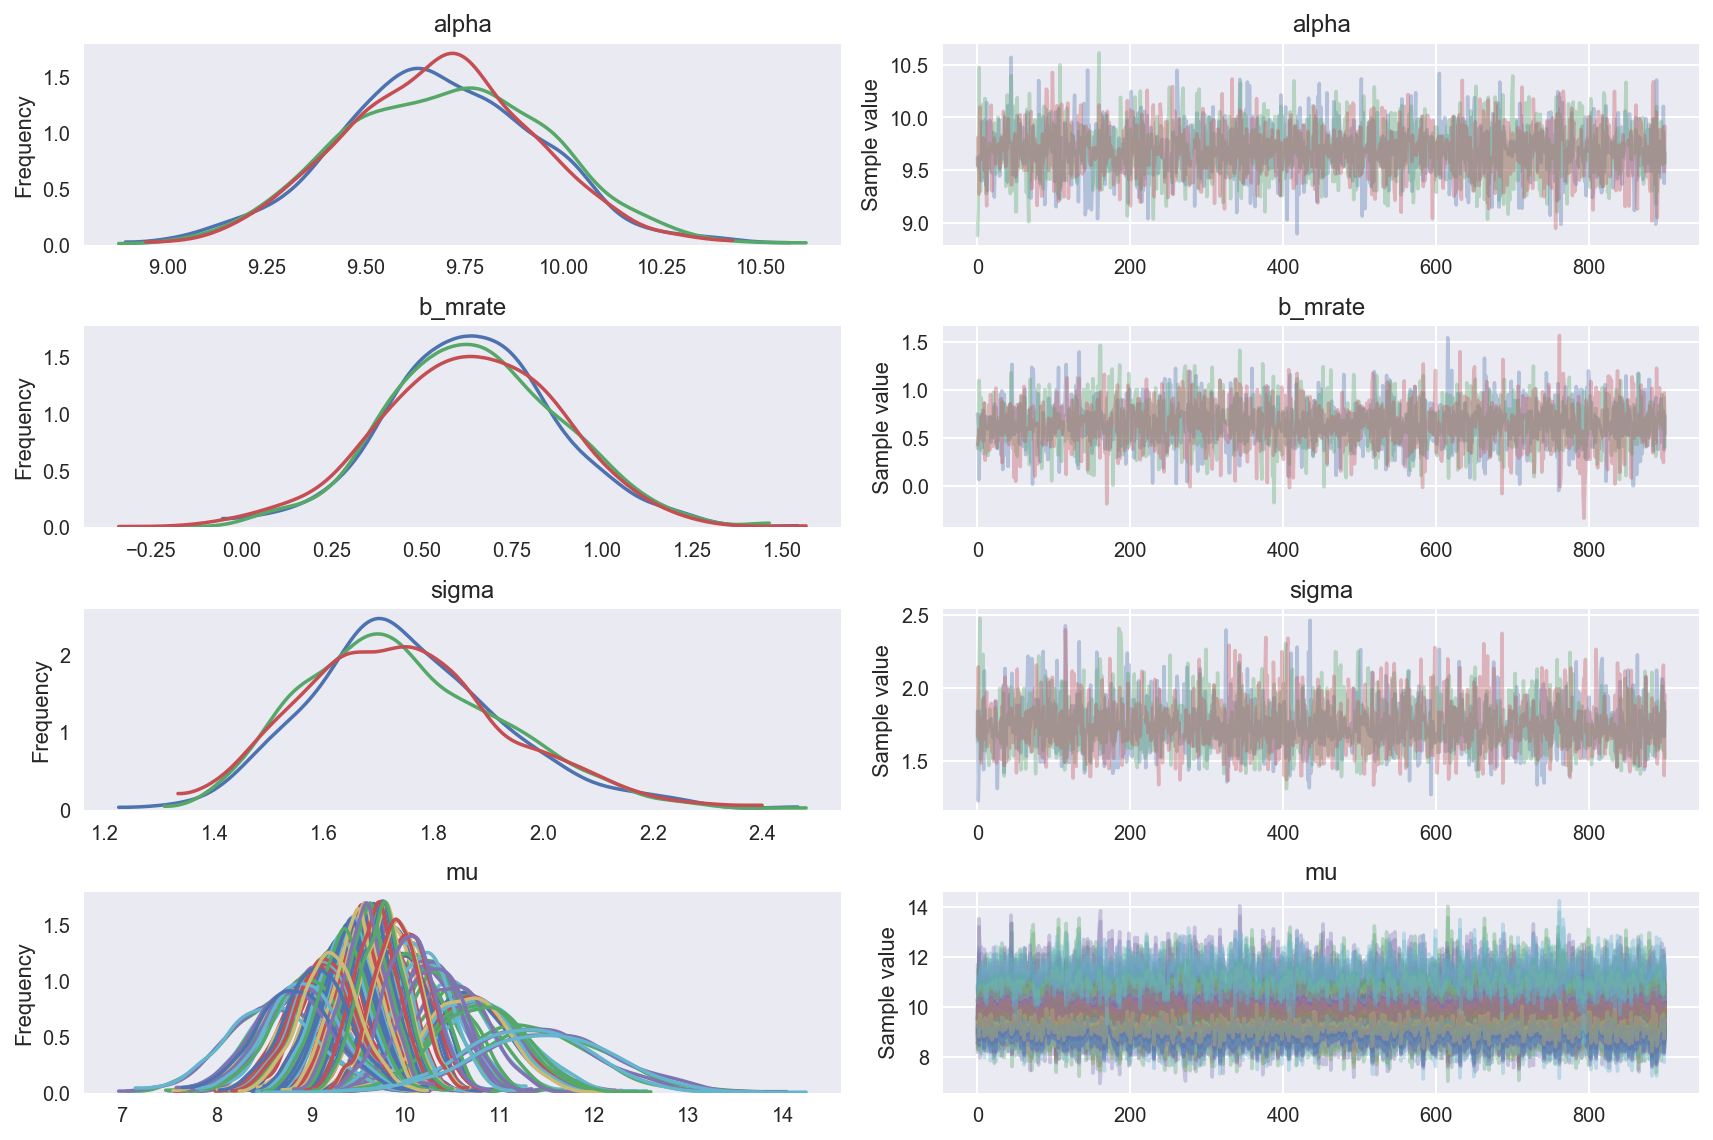

In [10]:
pm.traceplot(burned_trace_5_1_mrate);

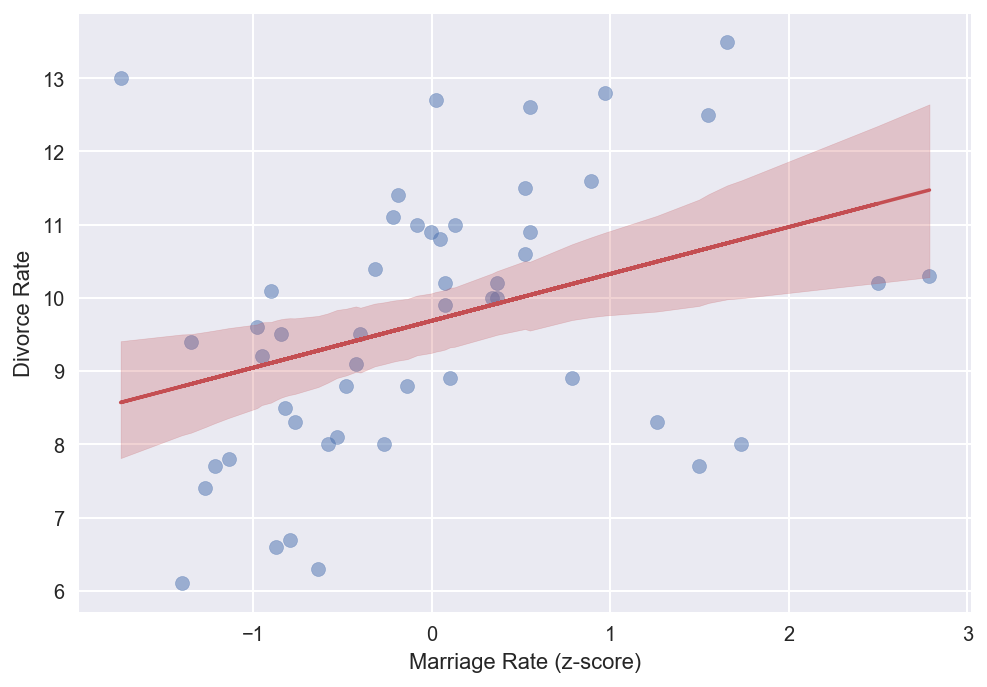

In [11]:
plot_regression_line(x=dat['mrate_z'], y=dat['Divorce'], mu=burned_trace_5_1_mrate['mu'],
                    xlab='Marriage Rate (z-score)', ylab='Divorce Rate')

In [12]:
pm.hpd(burned_trace_5_1_mrate['b_mrate'], 0.1)

array([0.27454895, 1.06304855])

Before making any inferences from this model, let's look at the univariate model for `Median Age at Marriave` vs. `Divorce`

***

### 5.1.2 A Model for Median Age at Marriage

In [13]:
# The priors are mostly the same since the variables have been standardized.

with pm.Model() as m5_1_mage: # median age at marriage
    alpha = pm.Normal('alpha', 10, 10)
    b_mage = pm.Normal('b_mage', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', alpha + b_mage * dat['mage_z'])
    divorce_rate = pm.Normal('divorce_rate', mu, sigma, observed = dat['Divorce'])
    
    trace = pm.sample(1000, tune=1000)
    burned_trace_5_1_mage = trace[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_mage, alpha]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1869.09draws/s]


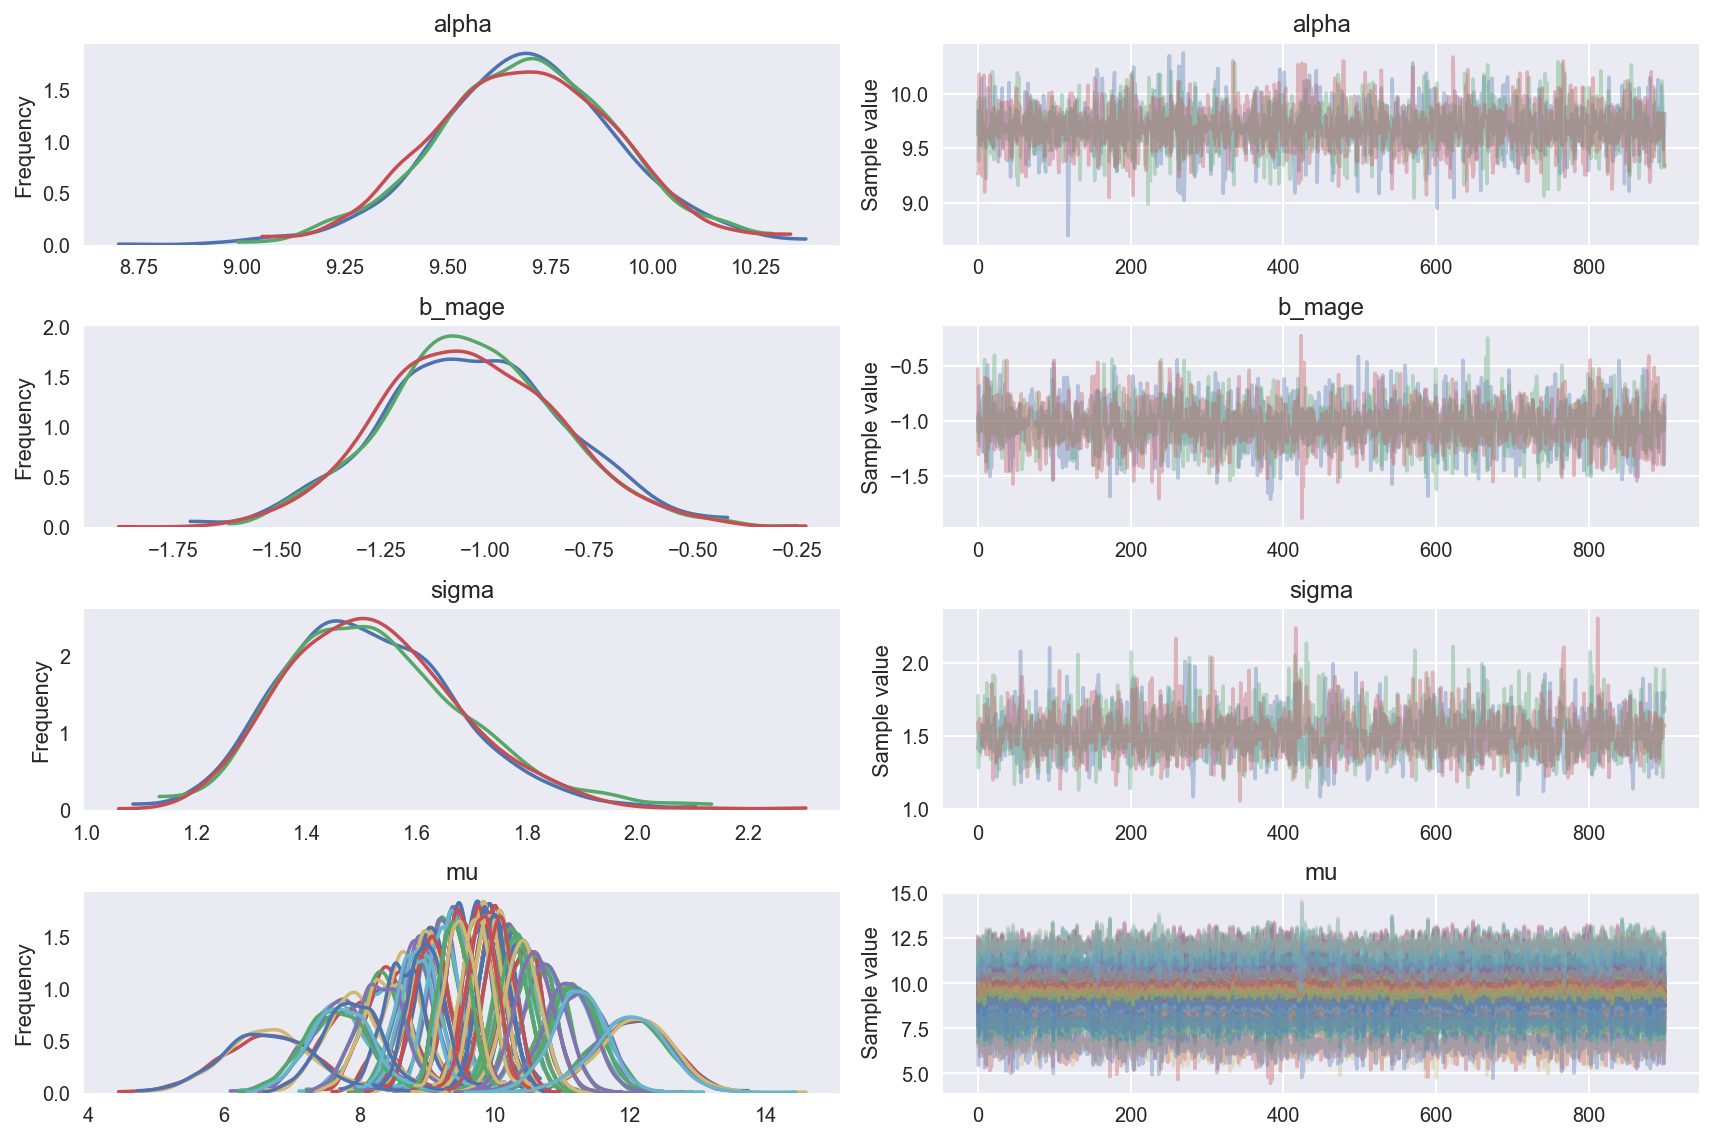

In [14]:
pm.traceplot(burned_trace_5_1_mage);

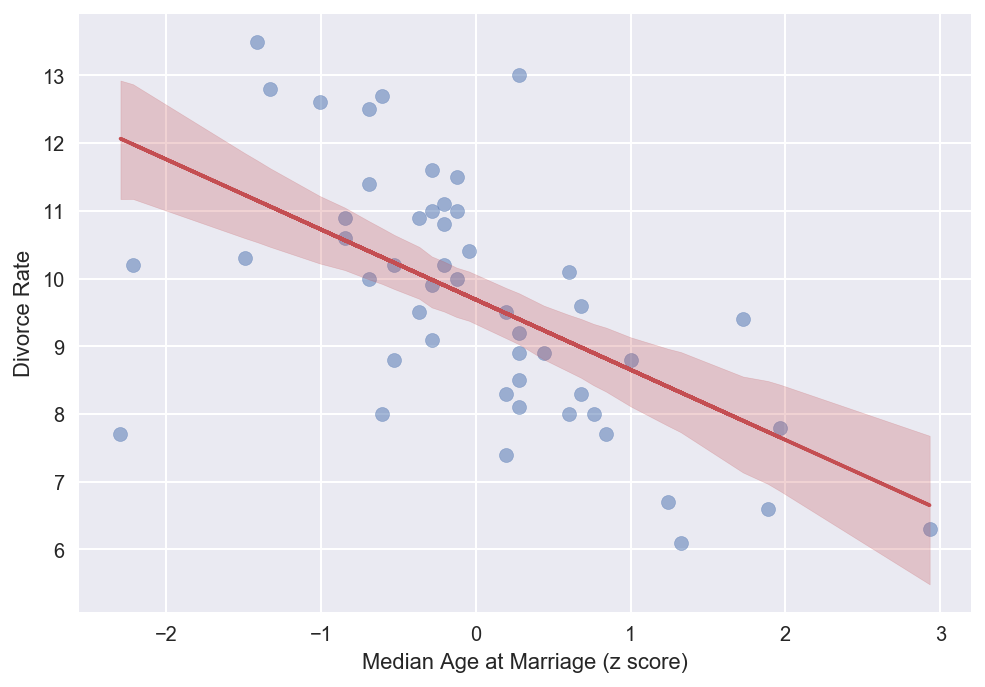

In [15]:
plot_regression_line(x=dat['mage_z'], y=dat['Divorce'], mu=burned_trace_5_1_mage['mu'],
                    xlab='Median Age at Marriage (z score)', ylab = 'Divorce Rate')

In [16]:
pm.hpd(burned_trace_5_1_mage['b_mage'], 0.1)

array([-1.41289269, -0.69937396])

***

### 5.1.3 From Simple to Multiple Regression Models

There is an apparent association between `Marriage Rate` and `Divorce`. The 90% HPDI for the slope is 0.23 to 1.0, so virtually all of the probability density lies above zero. Similarly, there is an apparent negative association between `Median Age at Marriage` and `Divorce`.

But:

(1) Does that necessarily mean that Marriage Rate *and* Median Age at Marriage are truly associated with Divorce Rate?

(2) Which predictor is *better*?

(3) Do these predictors provide independent value, or are they redundant, or do they cancel each other out?

These are questions that we aim to answer with multiple regression models as opposed to univariate models. In the next section we combine `Marriage Rate` and `Median Age at Marriage` as predictors in a multiple model.

We will see that Marriage Rate is *not* associated with Divorce Rate when Median Age at Marriage is added as a co-variate (when "controlling" for Median Age at Marriage).

In [17]:
# Code 5.4
# Build the model definition

with pm.Model() as m5_1:
    alpha = pm.Normal('alpha', 10, 10)
    b_mage = pm.Normal('b_mage', 0, 1)
    b_mrate = pm.Normal('b_mrate', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', alpha + b_mage * dat['mage_z'] + b_mrate * dat['mrate_z'])
    divorce_rate = pm.Normal('divorce_rate', mu, sigma, observed = dat['Divorce'])
    
    trace = pm.sample(1000, tune=1000)
    burned_trace_5_1 = trace[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_mrate, b_mage, alpha]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1552.17draws/s]


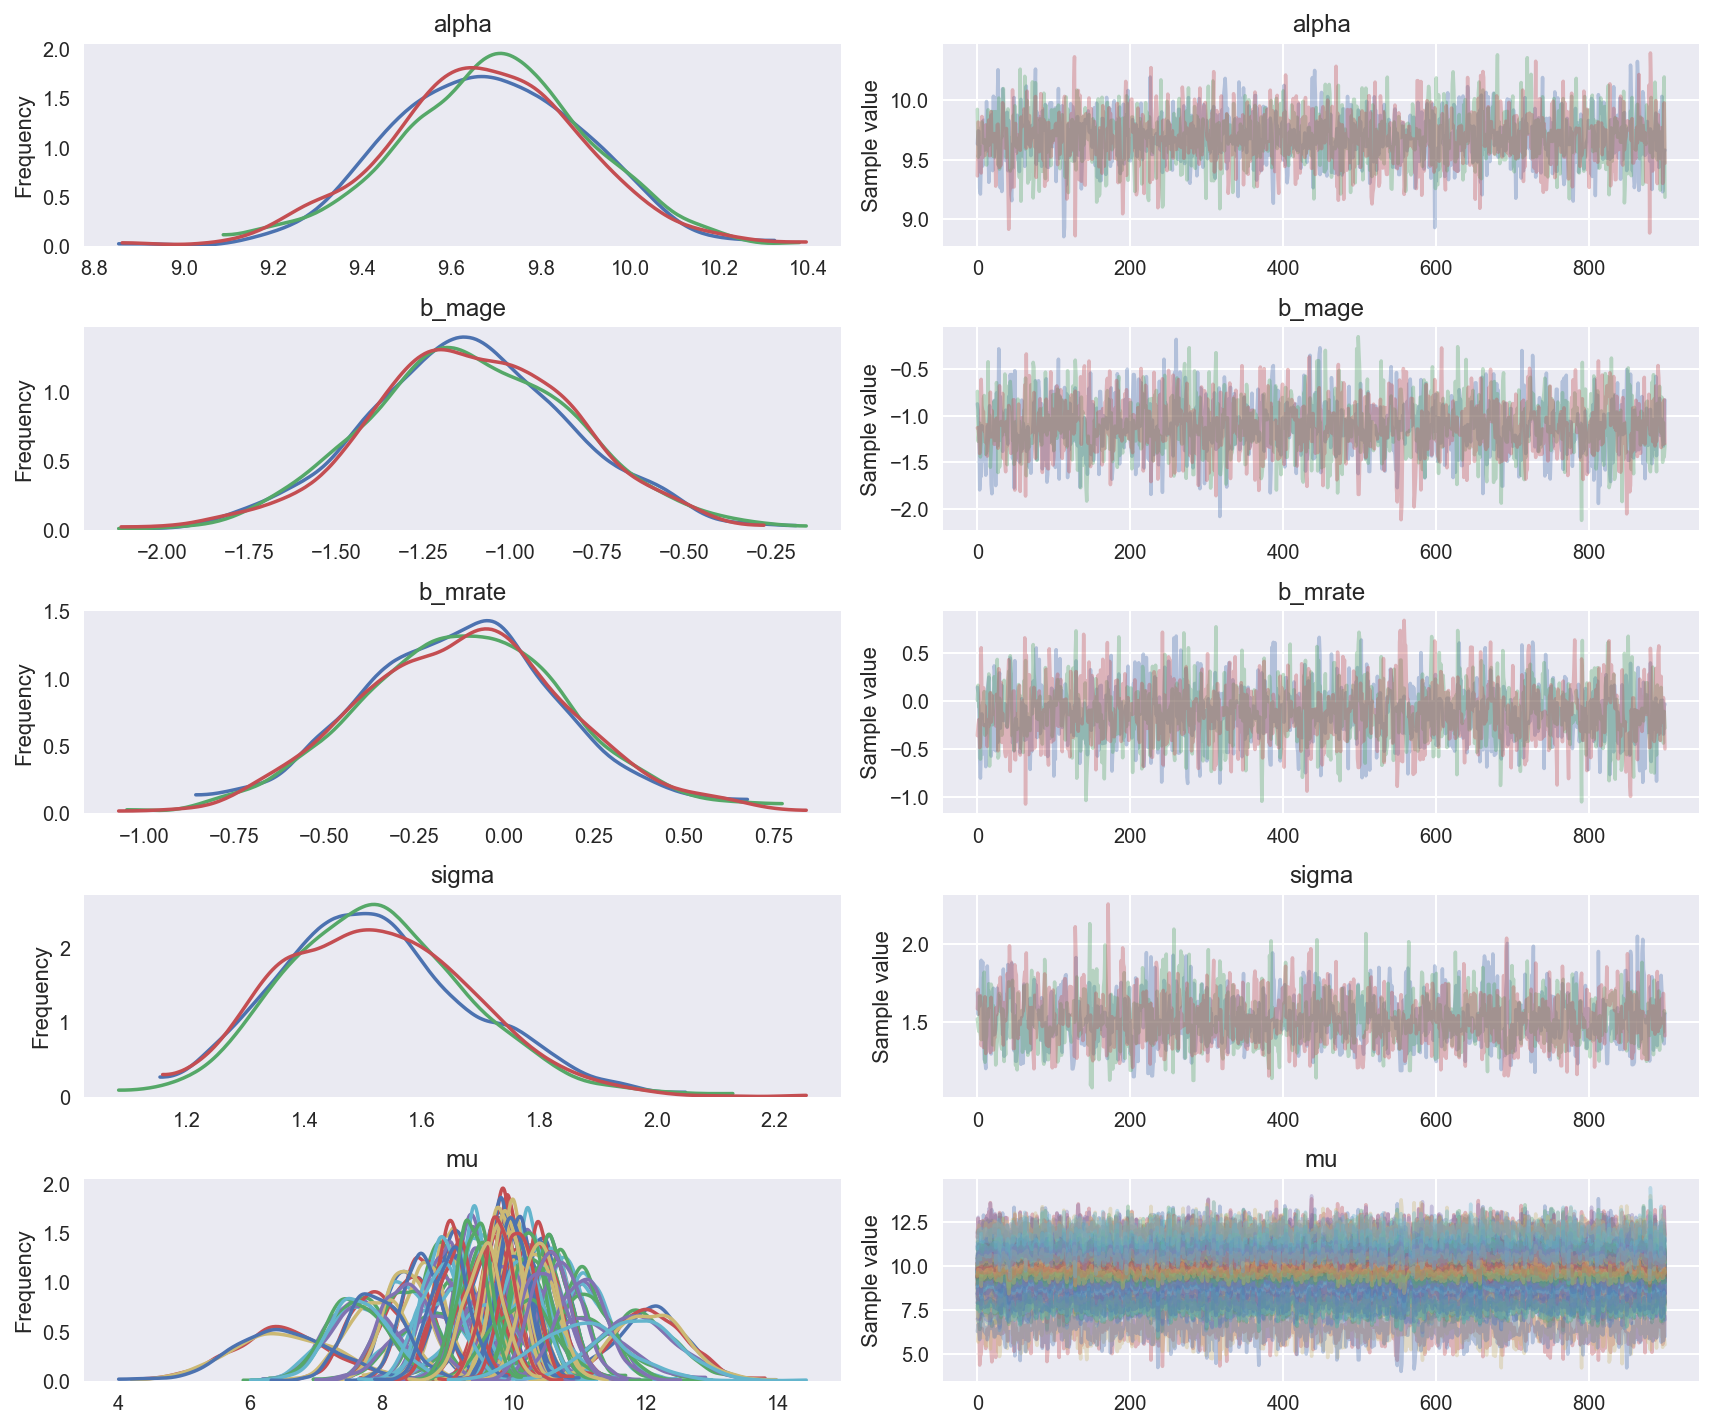

In [18]:
pm.traceplot(burned_trace_5_1);

In [19]:
pm.summary(burned_trace_5_1, alpha=.1)[:5].round(3)

mean     sd  mc_error  hpd_5  hpd_95     n_eff   Rhat
alpha     9.682  0.216     0.004  9.341  10.041  2435.735  1.001
b_mage   -1.114  0.294     0.006 -1.560  -0.578  2098.344  1.000
b_mrate  -0.119  0.291     0.007 -0.604   0.351  2108.049  1.000
sigma     1.520  0.162     0.004  1.262   1.784  1782.160  0.999
mu__0    10.355  0.280     0.005  9.911  10.821  2273.078  1.000

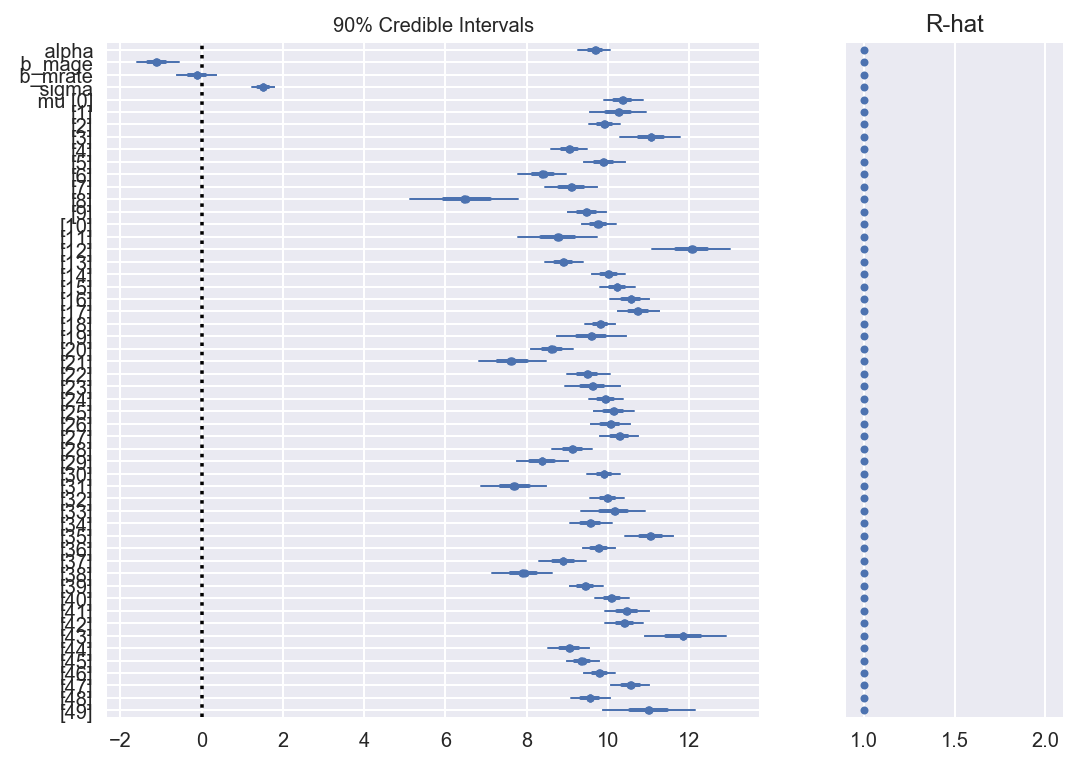

In [20]:
# Code 5.5
# Note that chain_spacing=0 condenses all 4 chains into 1 line; so things look more variable than they are.
pm.forestplot(burned_trace_5_1, varnames=['alpha', 'b_mage', 'b_mrate', 'sigma', 'mu'], alpha = 0.1, chain_spacing=0);

***

From this model, we see that after "controlling" for Median Age at Marriage, Marriage Rate has a very small effect, with considerable overlap with 0. I.e., the effect is small, and even then we don't know what direction the effect is. In contrast, Median Age at Marriage has its entire 90% probability distribution in the negative region. Another way of saying this is:

*Once we know Mediate Age at Marriage for a State, there is little additional predictive power in also knowing Marriage Rate of that State.* However, Marriage Rate is still predictor of Divorce Rate if Median Age at Marriage is not known.


In this plot we're also able to see the variability in our samples of $\mu$ from the posterior distribution.

***

### 5.1.4 Plotting Multiple Regression Posteriors

Visualizing the results of the posterior distributions is easy when you have only one predictor--a scatter plot with MAP line and credible intervals conveys most of the information that we care about.

With multiple variables we need multiple plots. There are a large number of techniques for visualizing multiple regressions, but none are suitable for all jobs, and most do not generalize beyond linear regression.

The book covers three types of plots to help interpret a multiple model:

(1) **Predictor Residual Plots**. These are plots of the outcom agsinst *residual* predictor values.

(2) **Counterfactual Plots**. These show the implied predictions for given values of the different predictors (i.e., changing the value of one predictor while holding the others constant). These are referred to as *counterfactual* in the book because they allow you to see how your model would make predictions on impossible observations.

(3) **Posterior Prediction Plots**. These show your models predictions against the data used to generate the model themselves. I.e., *retrodictions*.

***

#### 5.1.4.1 Predictor Residual Plots

When fitting a linear model, for example, we might look at the **Outcome Residuals** (i.e., Outcome vs. Residual) to see if our model is biased.

**Predictor Residuals** (i.e., Predictor vs. Residual) are a slightly different concept. A Predictor Residual is the average prediction error for an observation when we model *one predictor* using *all of the other predictors*. The result is that we can plot these predictor residuals against the outcome and see a sort of scatter plot that has already "controlled" for all of the other predictors.

This is equivalent to what is done in a multiple linear regression, but normally the model handles all of the details. We will see that modeling `Divorce Rates` on the predictor residuals is *equivalent* to our original multiple regression (m_5_1).

In our example with two predictors, we'll look at the predictor residual plots for `Marriage Rate ~ Median Age at Marriage` and vice-versa.


In [21]:
# Code 5.6
# Model of Median Age at Marriage on Marriage rate

with pm.Model() as m5_1_4_1a:
    alpha = pm.Normal('alpha', 10, 10)
    b_mage = pm.Normal('b_mage', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', alpha + b_mage * dat['mage_z'])
    mrate = pm.Normal('mrate', mu, sigma, observed = dat['mrate_z'])
    
    trace = pm.sample(1000, tune=500)
    burned_trace_5_1_4_1a = trace[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_mage, alpha]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:02<00:00, 1585.18draws/s]
The acceptance probability does not match the target. It is 0.8813267397054196, but should be close to 0.8. Try to increase the number of tuning steps.


In [22]:
# Code 5.7
# Compute the residuals
mu_predicted = burned_trace_5_1_4_1a['mu'].mean(0)
residuals = dat['mrate_z'] - mu_predicted

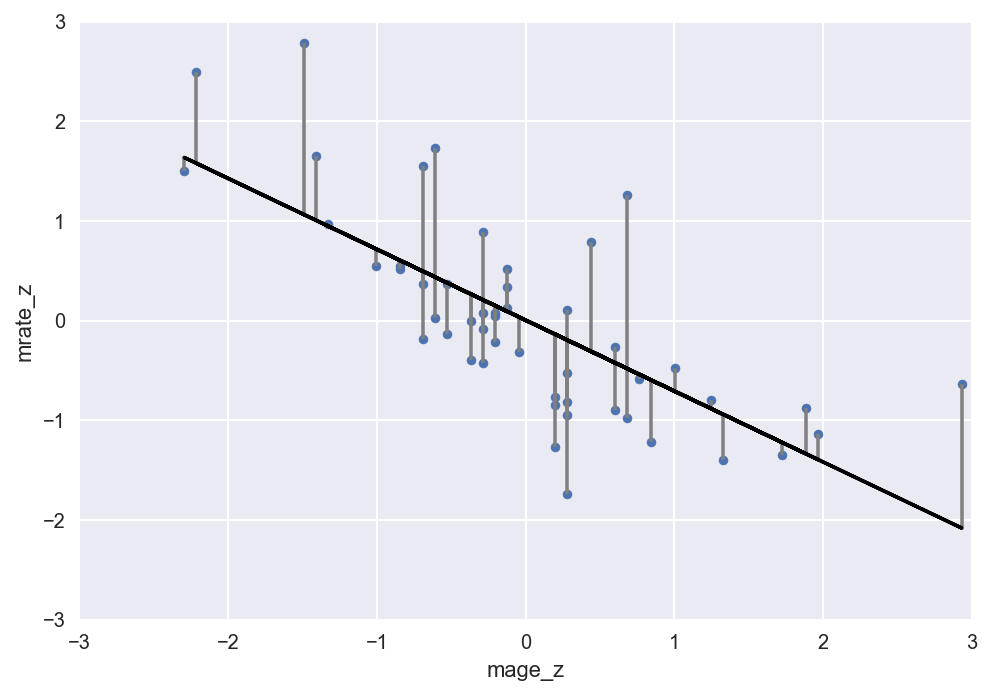

In [23]:
# Code 5.8

idx = np.argsort(dat['mrate_z'])
dat.plot('mage_z', 'mrate_z', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(dat.mage_z[idx], mu_predicted[idx], 'k')
plt.vlines(dat['mage_z'], mu_predicted, mu_predicted + residuals, colors='grey');

The residuals in the plot above are the variation in marriage rate that is left over after taking out the purely linear relationship between marriage rate and age at marriage.

In [24]:
# Model of `Marriage rate residuals` (after Median Age at marriage) on `Divorce Rate`

with pm.Model() as m5_1_4_1b:
    alpha = pm.Normal('alpha', 10, 10)
    b_residuals = pm.Normal('b_residuals', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', alpha + 
                          b_residuals * (dat['mrate_z'] - burned_trace_5_1_4_1a['mu'].mean(0)))    # These are the `mrate` residuals
    divorce = pm.Normal('divorce', mu, sigma, observed = dat['Divorce'])
    
    trace = pm.sample(1000, tune=500)
    burned_trace_5_1_4_1b = trace[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_residuals, alpha]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:02<00:00, 1564.11draws/s]


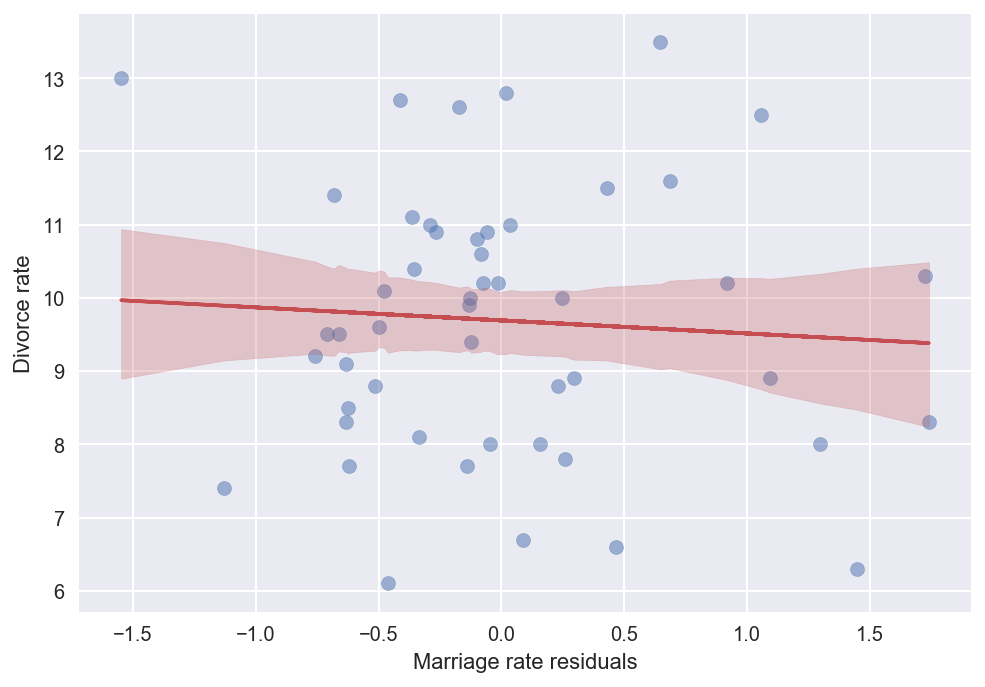

In [25]:
plot_regression_line(x=residuals,
                    y=dat['Divorce'],
                    mu=burned_trace_5_1_4_1b['mu'],
                    hdpi=0.1,
                    xlab='Marriage rate residuals',
                    ylab='Divorce rate')

In [26]:
pm.summary(burned_trace_5_1_4_1b)[0:4]

mean        sd  mc_error   hpd_2.5   hpd_97.5        n_eff  \
alpha        9.692325  0.260258  0.004209  9.187050  10.206264  3359.324736   
b_residuals -0.178021  0.360967  0.006195 -0.910121   0.504035  3296.456381   
sigma        1.881684  0.195576  0.003350  1.526383   2.282519  3640.645286   
mu__0        9.765832  0.298246  0.005024  9.173592  10.349682  3608.417415   

                 Rhat  
alpha        1.000301  
b_residuals  0.999721  
sigma        0.999610  
mu__0        0.999759

***

If we take the variable `residuals` and plug it back into a regression on `Divorce Rate` we get the same slope\* as in the original multiple regression (m_5_1). Essentially all we have done is controlled for `Median age at Marriage` manually instead of allowing the model to do it internally.

\* My slopes aren't the same but according to the book they are supposed to be. So I must have done something wrong.

These plots also reinforce the message that **what regression models do is quantify the remaining association _(of each predictor with the outcome)_ after already knowing the other predictors.**

Linear models do this with a very specific additive model of how the variables relate to one another. In cases where the variables are related in non-additive ways this type of "control" doesn't really hold. Luckily, there are more general ways to see the effect of a variable in a model. In the next section we turn to *counterfactual plots*.

***

#### 5.1.4.2 Counterfactual plots

Counterfactual plots are so-called in the book because they allow you to produce plots that contain dummy observations that could never exist. For example, combinations like very high median age of marriage and very high marriage rate--No states exist with such a combination but we can see how the model *would have predicted* the divorce rate for such a state.

When we make a counterfactual plot we essentially hold all variables constant except for the predictor of interest. Below is an example of a counterfactual plot that shows the impact of `Marriage Rate` on Divorce Rates.

The plot has the same slope as the predictor vs. residual plot and the multiple regression $\beta$. The methods to generate dummy data for counterfactual plots are generalizable beyond linear models, however.

This example is trivial, but in other examples, where more than one predictor variable has a meaningful impact on the outcome, counterfactual plots are very valuable. While these plots help to understand the model, it is also important not to be misled by them, as they may imply predictions for impossible combinations of predictor values.

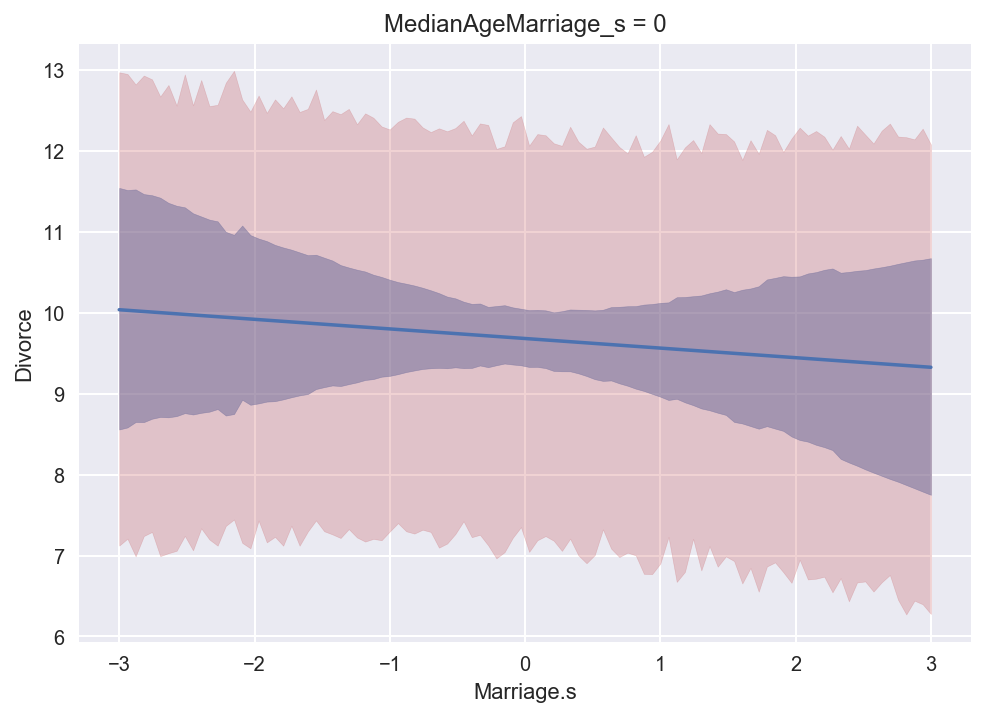

In [27]:
# Range of `marriate rate.s` values to create "dummy" observations over
x_space = np.linspace(-3, 3, 100)

# Compute the model-predicted means
# Note the x_space[:,None] broadcasts burned_trace from (3600,) to (, 3600) [I don't understand why]
mu_predicted = burned_trace_5_1['alpha'] + burned_trace_5_1['b_mrate'] * x_space[:,None]

# 90% credible interval for mean
mu_hpd = pm.hpd(mu_predicted.T, alpha = 0.1)

# 90% prediction interval
divorce_hpd = pm.hpd(stats.norm.rvs(mu_predicted, burned_trace_5_1['sigma']).T, alpha = 0.1)


plt.plot(x_space, mu_predicted.mean(1), 'C0');
plt.fill_between(x_space, mu_hpd[:,0], mu_hpd[:,1], color='C0', alpha=0.5)
plt.fill_between(x_space, divorce_hpd[:,0], divorce_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Marriage.s')
plt.ylabel('Divorce')
plt.title('MedianAgeMarriage_s = 0');

***

#### 5.1.4.2 Posterior Prediction Plots

Posterior prediction plots help you check the model fit. We've done this before in Chapter 3, where we ran the training data through the model again to see how similar the predicted results were to the training data.

We will generate the data and then plot them in a number of ways.


##### Predicted vs. Observed Divorce Rates

In [28]:
# Code 5.11
# This is simply predicted divorce rates vs. the observed divorce rates.

mu_predicted = burned_trace_5_1['mu']
mu_hpd = pm.hpd(mu_predicted, alpha=0.1).T

# Sample 1000 data sets from the posterior and predict using m5_1 
# divorce_predictions = pm.sample_ppc(burned_trace_5_1, samples=1000, model = m5_1)['divorce_rate']

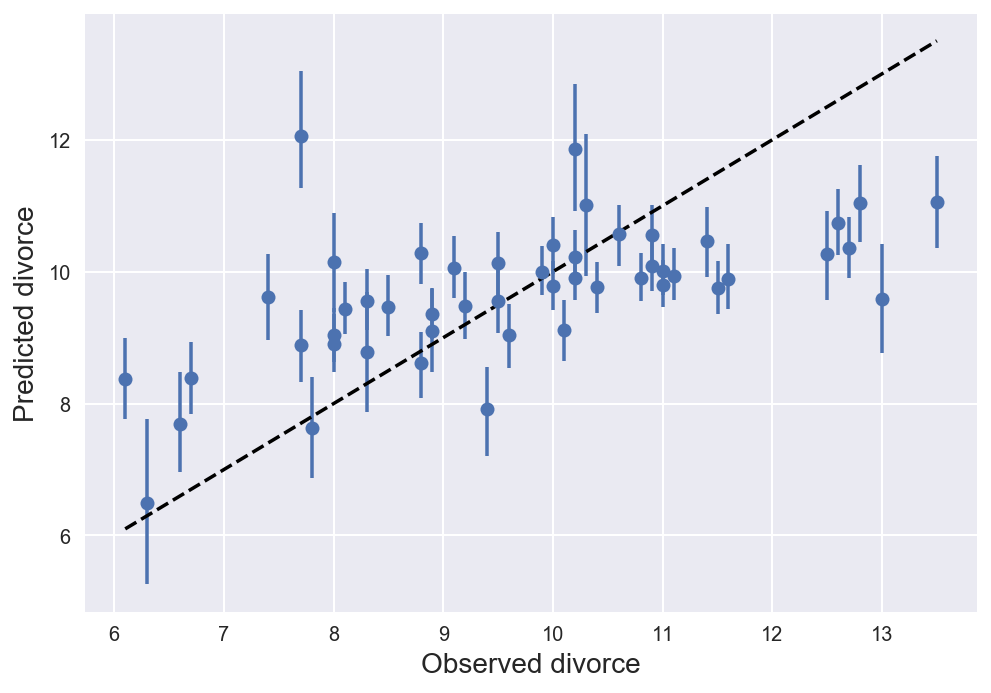

In [29]:
plt.errorbar(dat['Divorce'], 
             mu_predicted.mean(0),
             yerr=np.abs(mu_predicted.mean(0)-mu_hpd),    # 90% CI for mean
             marker='o',
             linestyle='')

plt.xlabel('Observed divorce', fontsize=14)
plt.ylabel('Predicted divorce', fontsize=14)

# Black dashed line to represent perfect concordance between predicted and observed outcomes.
min_x, max_x = dat.Divorce.min(), dat.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

**

Models are not expected to perfectly retrodict the sample; it is trivial to create a model that perfectly fits the training data. We are more interested in out-of-sample predictions.

Posterior predictive plots help visualize what types of observations our model gets (mostly) correct, and which ones it gets (mostly) incorrect (eg., by examining the *pattern* of error in the predictions to get "large world" context around the model).

For example, we see that our model under-predicts divorce rates for States with high observed divorce rates and over-predicts for States with low observed divorce rates.


##### Predicted vs. Observed Reisdual Plots

C:\Users\alexa\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 609.36it/s]


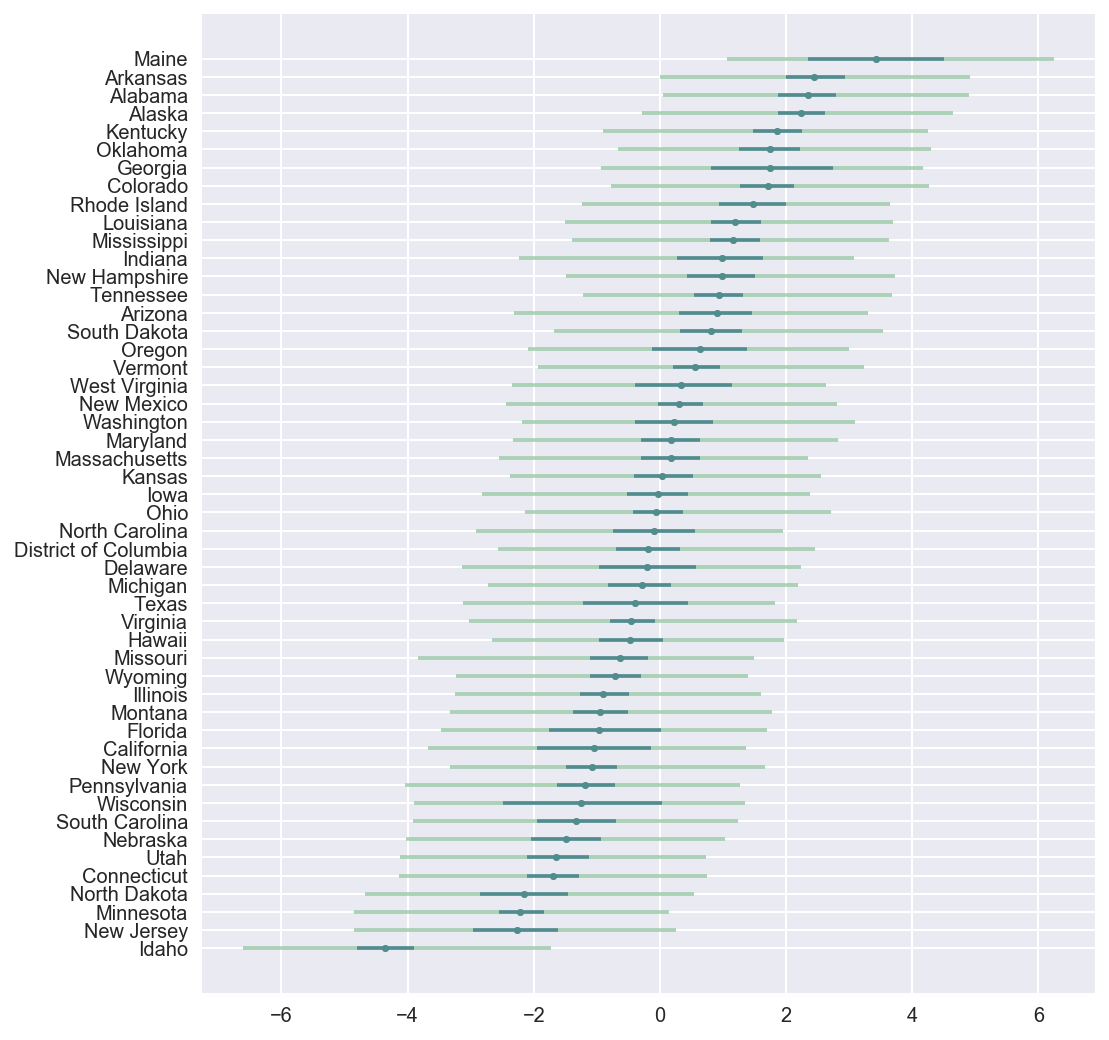

In [30]:
# Code 5.14

# Compute residuals of observed vs. predicted means
residuals = dat['Divorce'] - mu_predicted.mean(0)
idx = np.argsort(residuals)

# Sample from the posterior to construct prediction intervals
divorce_predictions = pm.sample_ppc(burned_trace_5_1, samples=500, model=m5_1)['divorce_rate']
divorce_hpd = pm.hpd(divorce_predictions, alpha=0.1).T

plt.figure(figsize=(8, 9))
# Mean + Credible Interval
plt.errorbar(residuals[idx],
            dat['Location'][idx],    # Sort States by residuals
            xerr=np.abs(mu_predicted.mean(0)-mu_hpd),
             marker='.',
            linestyle='')

# Prediction Interval
plt.errorbar(residuals[idx],
            dat['Location'][idx],    # Sort States by residuals
            xerr=np.abs(mu_predicted.mean(0)-divorce_hpd),
             marker='.',
            linestyle='',
            alpha=0.5);

***

With these residual plots its much easier to see large model failures, such as Idaho and Maine. However, for large data sets this type of plot will take up a lot of space.

***

## 5.2 Masked Associations

Aside from identifying/minimizing spurious correlations, multiple regression models are also very useful in identifying masked associations.

In nature, one predictor might be associated with the outcome, but also associated with a second predictor that is inversely associated with the outcome. If one were to plot bivariate Outcome vs. Predictor it is possible that no association would be seen.

This is common in nature, and sometimes the only way to reveal these associations is by using multiple regression models.

***
#### Example: Masked Associations

* Two predictors, `x_pos` and `x_neg`, are correlated.

* The outcome, `y`, is positively associated with `x_pos` and negatively associated with `x_neg` (as their names would imply)

Even though we know there is an association between each of the predictors on the outcome (because we simulated the data), no association can be seen in the pairplots. The closer the correlation gets to -1 or 1, the more this problem is magnified. 

As the correlation approaches -1 or 1, the variables contain essentially the exact same information, and there is very little hope for a statistical model to tease out the differences.

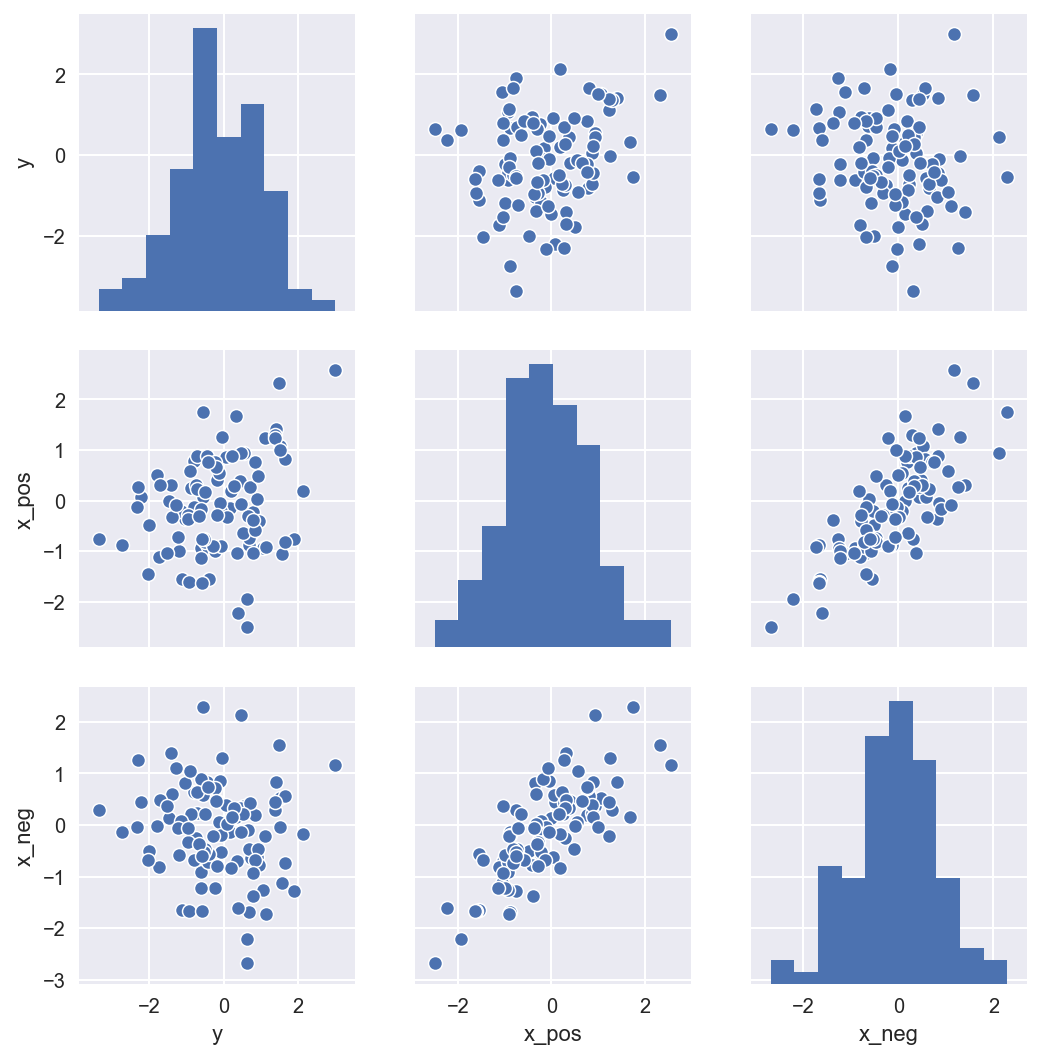

In [31]:
# Code 5.28

N = 100
rho = 0.8
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(rho*x_pos, (1-rho**2)**0.5)
y = stats.norm.rvs(x_pos - x_neg)
d = pd.DataFrame([y, x_pos, x_neg]).T
d.columns = ['y', 'x_pos', 'x_neg']
sns.pairplot(d);

***

### 5.2.1. Primate Brain Size and Milk Energy Density

*"Do primates with bigger brains have more energy dense milk?"*

This is a popular hypothesis, and it would make sense, given that brains are so energetically demanding and animals with big brains are underdeveloped at birth and must grow after birth. However, this type of question is difficult to solve with bivariate regression because there are so many variables that vary between species. Real associations are masked by associations with other variables. In the sections below, we'll consider only one covariate: bodyweight.

We'll start by loading in the data:

In [32]:
milk_raw = pd.read_csv('Data/milk.csv', sep=';')
print(milk_raw.shape)
milk_raw.head()

(29, 8)


clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

In [33]:
# PyMC3 does not work with missing data; drop incomplete cases.
# In this data set, only `neocortex.perc` has missing data.
# Note in later chapters we will use more intelligent ways of handling missing data.

milk = milk_raw.dropna()
print(milk.shape)

(17, 8)


For now, we will consider the following variables:

`kcal.per.g` -- Kilocalories of energy per gram of milk

`neocortex.perc` -- The percentage of the brain that is neocortex (i.e., the front part that humans have a lot of)

`mass` -- Average female body mass for the species, in kilograms



#### 5.2.1.1 A Simple Linear Regression

Before we factor in `mass`, let's look at the bivariate association between `kcal.per.g` and `neocortex.perc`:

In [34]:
# Code 5.17

with pm.Model() as m5_5:
    a = pm.Normal('a', 0, 100)
    b_n = pm.Normal('b_n', 0, 1)  
    sigma = pm.Uniform('sigma', 0, 1)
    mu = pm.Deterministic('mu', a + b_n * milk['neocortex.perc'])
    kcal = pm.Normal('kcal', mu, sigma, observed=milk['kcal.per.g'])
    
    m5_5_trace = pm.sample(2000, tune=1000)[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_n, a]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 9000/9000 [00:13<00:00, 663.25draws/s]
The acceptance probability does not match the target. It is 0.8814263229266066, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847199874422056, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


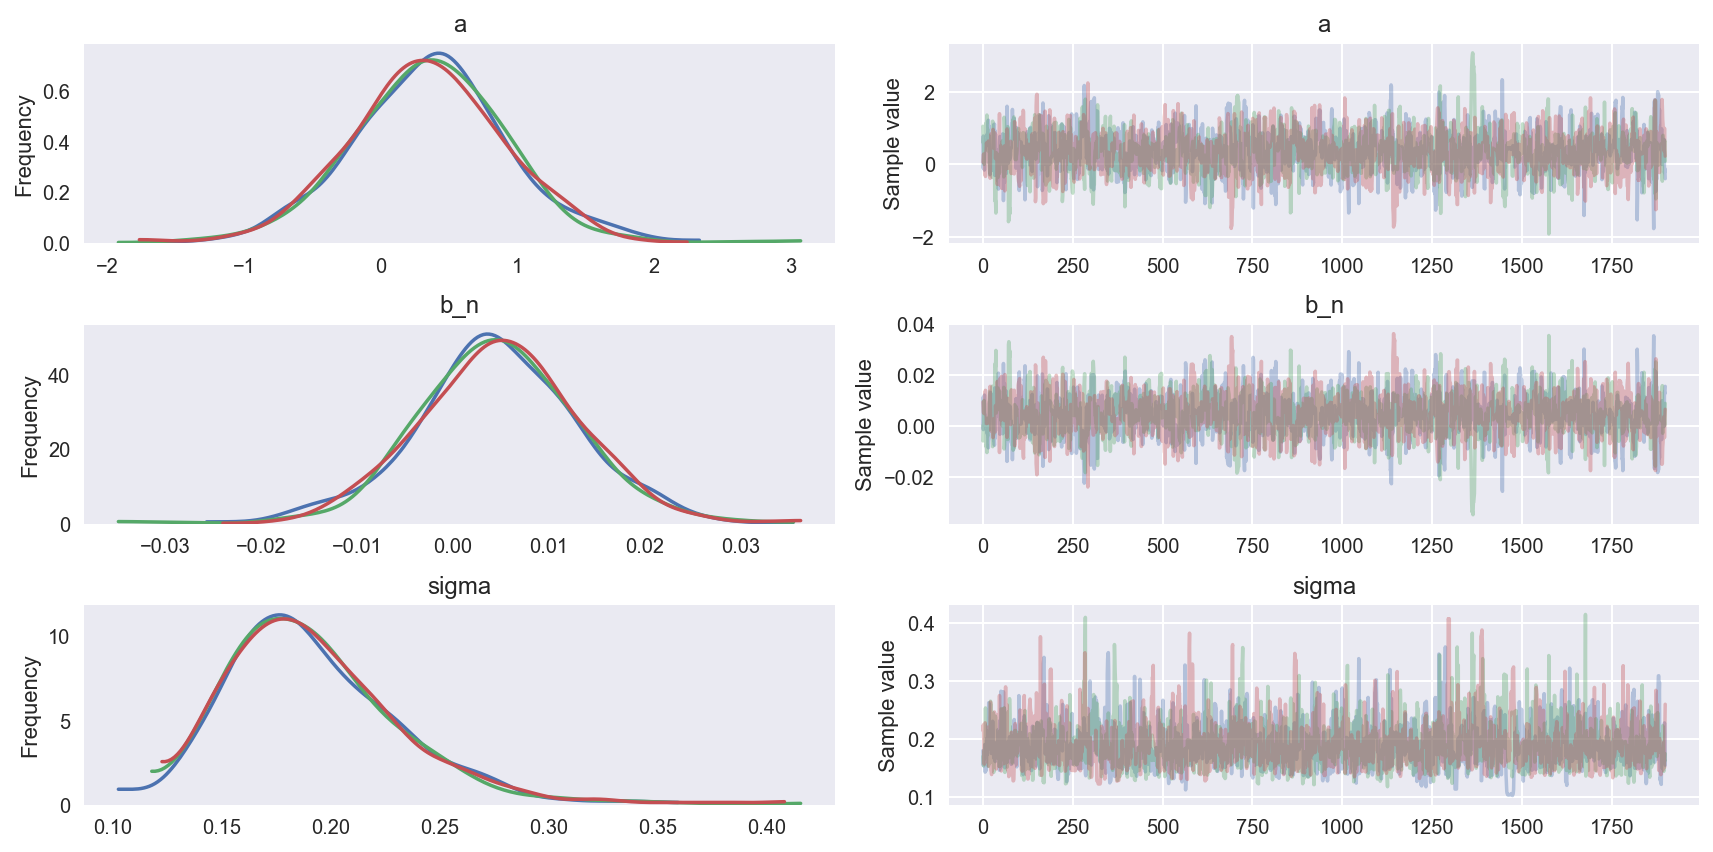

In [35]:
varnames = ['a', 'b_n', 'sigma']
pm.traceplot(m5_5_trace, varnames);

In [36]:
pm.summary(m5_5_trace, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      0.343  0.563     0.014   -0.587     1.196  1464.558   1.0
b_n    0.005  0.008     0.000   -0.009     0.018  1458.138   1.0
sigma  0.192  0.040     0.001    0.134     0.250  1486.931   1.0

***

$\beta_n$ is extremely small: 0.004; and the confidence is low: the hpd 89% ranges from -0.01 to 0.017.

That is, the model predicts that for every 1% increase in `neocortex.perc`, the energy density of milk will increase by 0.004 kcal per g. And the model isn't even very confident. In our data set the % of neocortex ranges from 55% to 76%. According to our model, the range of kcal per g from the smallest to the largest neocortex species would be 0.09kcal per gram. This isn't so impressive given that our data range from 0.46kcal/g to 0.97kcal/g.

In [37]:
print('Neocortex %:'); print(milk['neocortex.perc'].min()); print(milk['neocortex.perc'].max())
print('Milk Calories:'); print(milk['kcal.per.g'].min()); print(milk['kcal.per.g'].max())

Neocortex %:
55.16
76.3
Milk Calories:
0.46
0.97


In [38]:
m5_5_trace['b_n'].mean() * (milk['neocortex.perc'].max()- milk['neocortex.perc'].min())

0.09862594384492065

#### Code 5.23

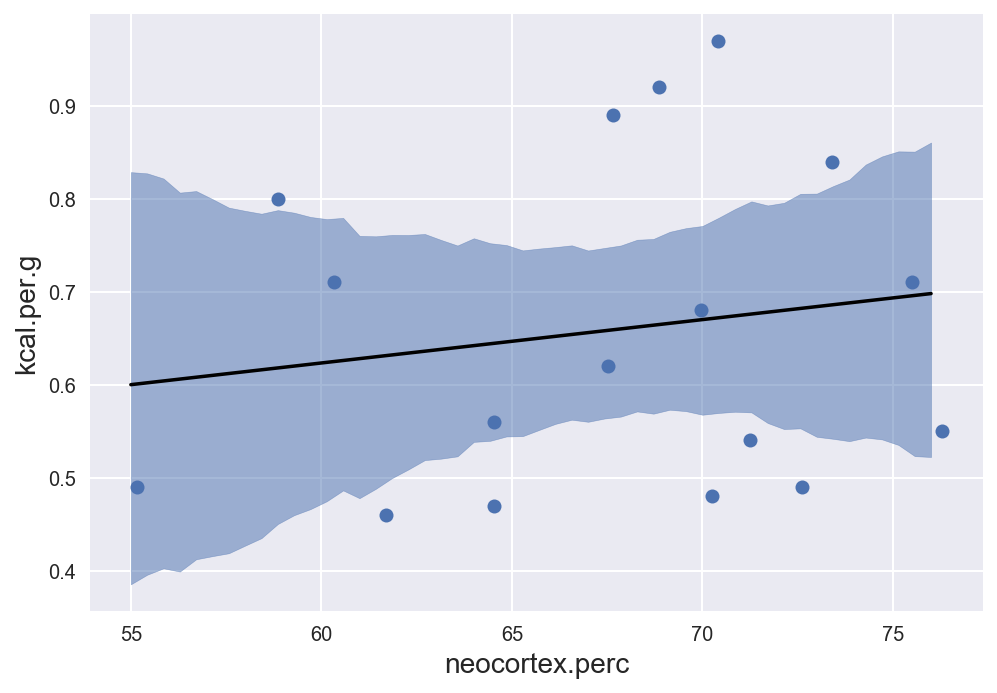

In [39]:
x_space = np.linspace(55, 76, 50)
mu_predicted = m5_5_trace['a'] + m5_5_trace['b_n'] * x_space[:,None]
mu_hpd = pm.hpd(mu_predicted.T)    # Don't know why it's ".T" inside the function

plt.plot(milk['neocortex.perc'], milk['kcal.per.g'], 'C0o')
plt.plot(x_space, mu_predicted.mean(1), 'k')
plt.fill_between(x_space, mu_hpd[:,0], mu_hpd[:,1], color='C0', alpha=0.5)

# plt.plot(x_space, mu_hpd[:,0], 'k--')
# plt.plot(x_space, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc', fontsize=14)
plt.ylabel('kcal.per.g', fontsize=14);

***

#### 5.2.1.2 Simple Linear Regression with a Second Predictor: Bodyweight

When we plot the MAP line for `kcal.per.g` vs. `neocortex.perc` we see a weak positive trend, but also considerable uncertainty in the credible interval. You could build all sorts of lines that would fit in this CI, including negatively sloped ones.

We will now look to a second predictor, and see how it is associated with milk energy density.

First we must note that the body mass across species is not Normally distributed. We perform a log-transformation to bring them closer to Normal. What we are saying when we include `log(mass)` in our regression is that we believe that `mass` is associated with milk energy density in a *log-normal* fashion.

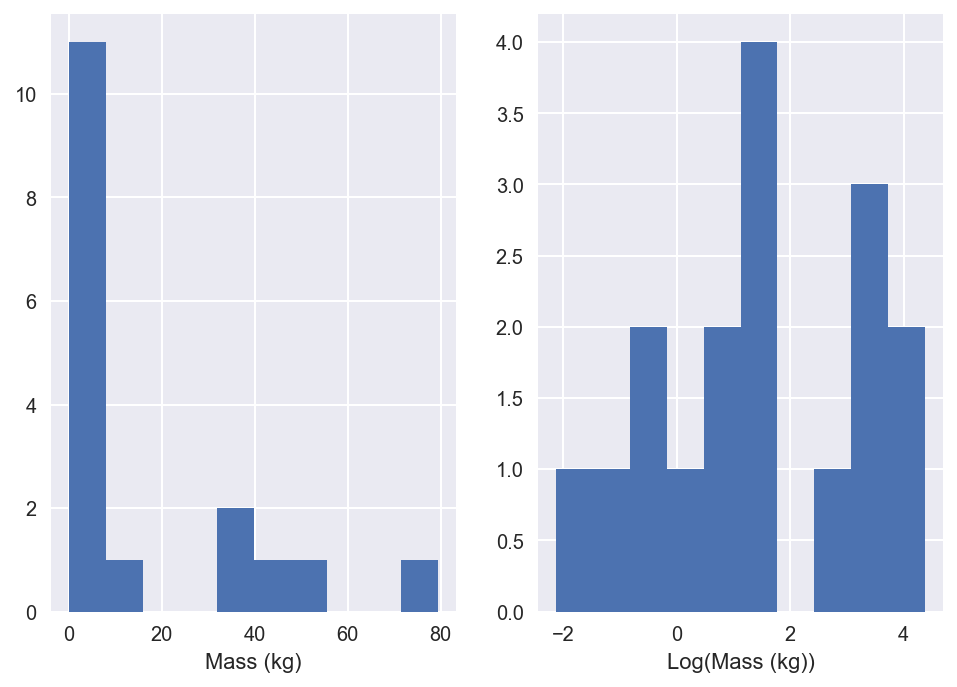

In [40]:
plt.subplot(121)
plt.hist(milk['mass'])
plt.xlabel('Mass (kg)')
plt.subplot(122)
plt.hist(np.log(milk['mass']));
plt.xlabel('Log(Mass (kg))');

In [41]:
milk['log_mass'] = np.log(milk['mass'])

C:\Users\alexa\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now let's run a model for `kcal.per.g` v. `mass`:

In [42]:
# Code 5.25

with pm.Model() as m5_6:
    a = pm.Normal('a', 10, sd=100)
    b_m = pm.Normal('b_m', 0, 1)
    sigma = pm.Uniform('sigma', 0, 1)
    mu = pm.Deterministic('mu', a + b_m * milk['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    m5_6_trace = pm.sample(1000, tune=1000)[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_m, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1658.03draws/s]


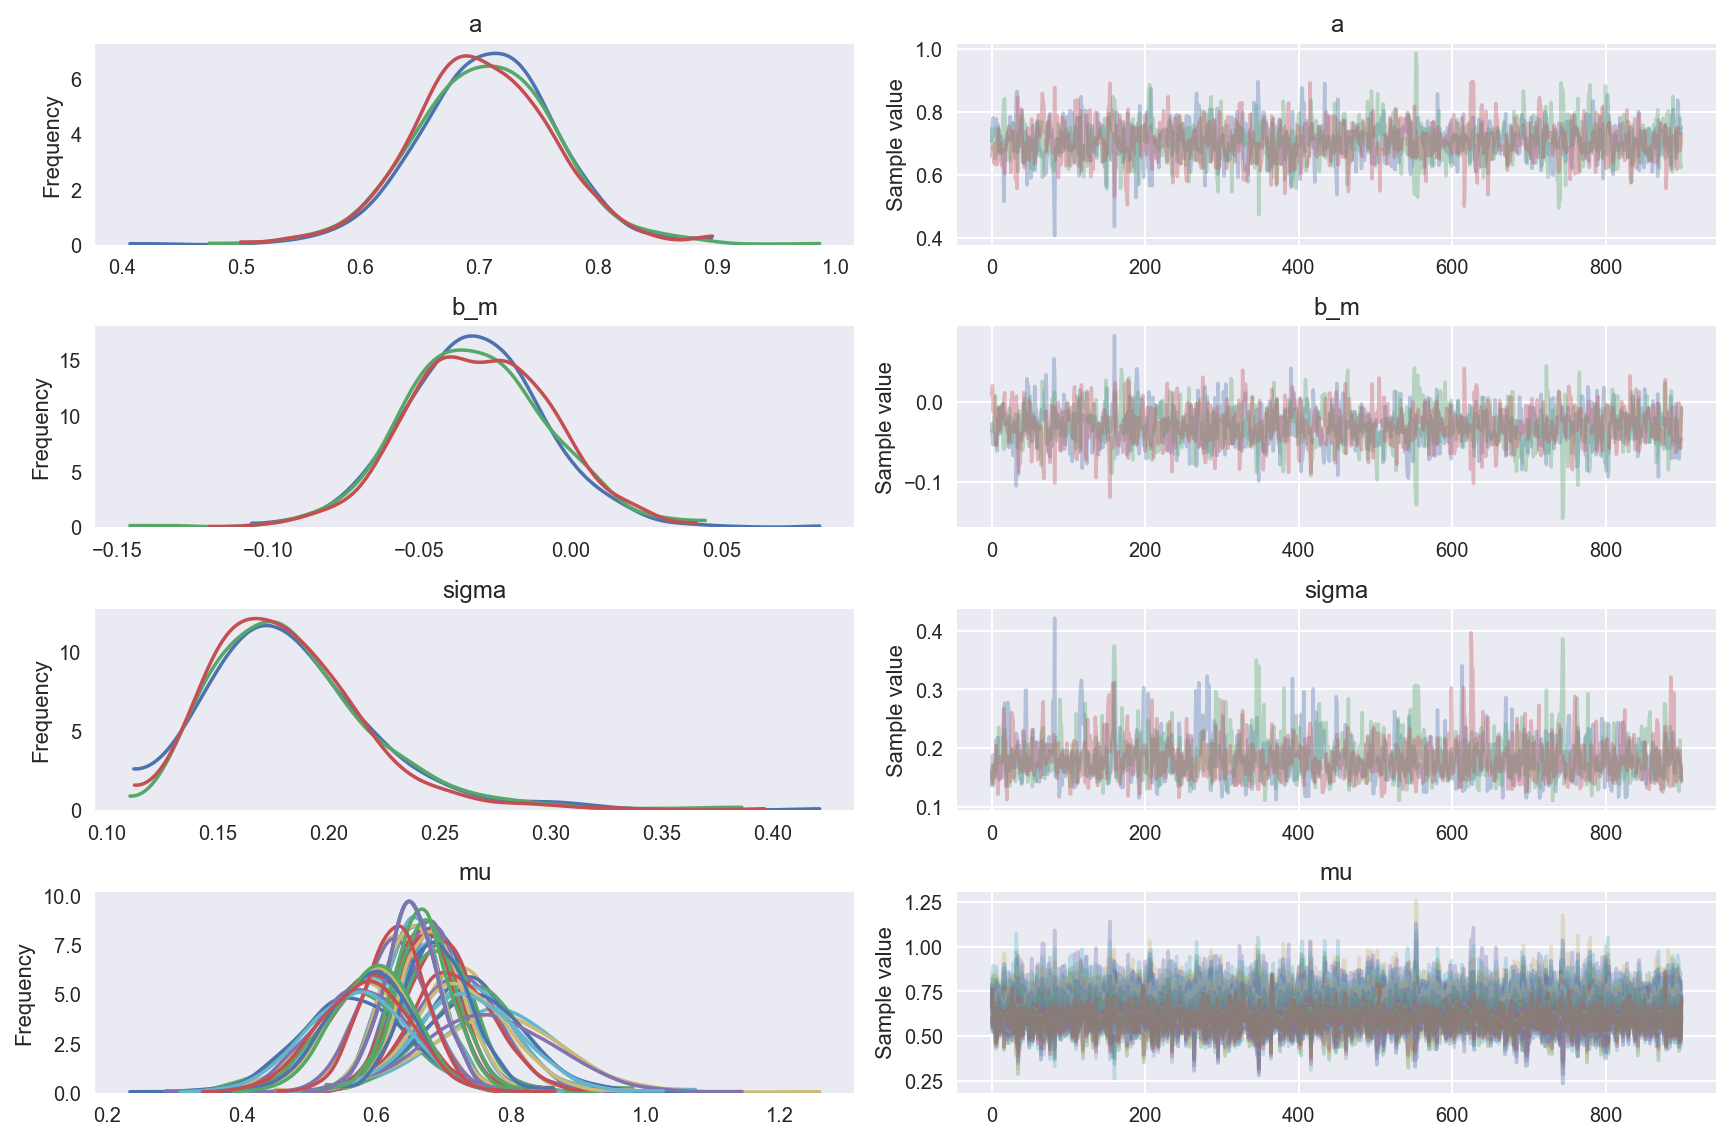

In [43]:
varnames = ['a', 'b_m', 'sigma']
pm.traceplot(m5_6_trace);

In [44]:
pm.summary(m5_6_trace, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      0.705  0.059     0.001    0.619     0.798  1508.782  1.000
b_m   -0.031  0.024     0.001   -0.067     0.007  1487.310  1.001
sigma  0.183  0.036     0.001    0.130     0.232  1270.041  1.001

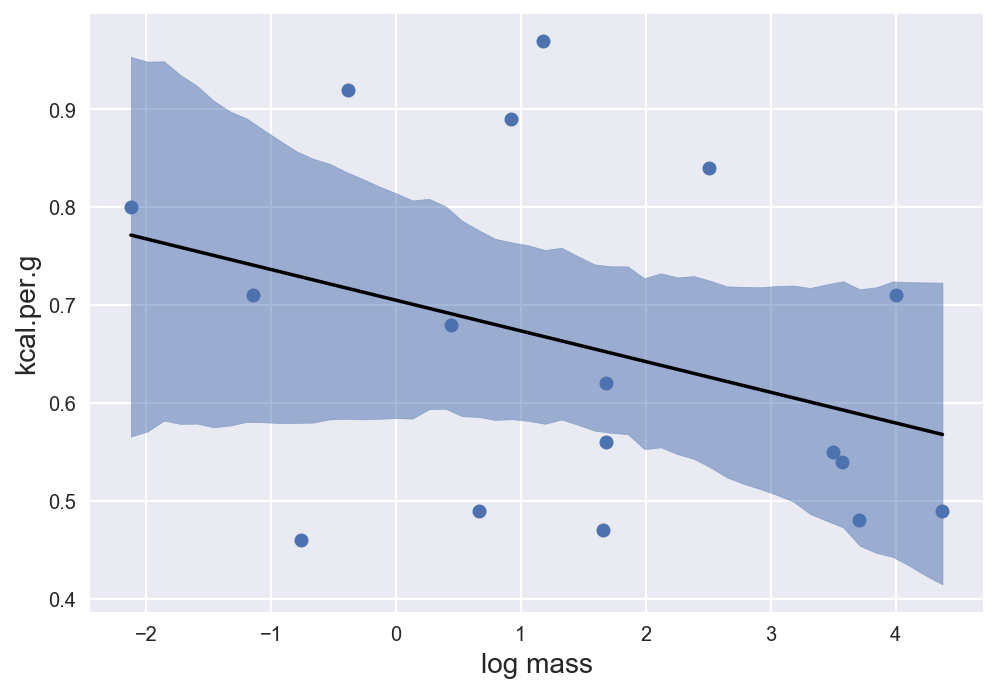

In [45]:
x_space = np.linspace(milk['log_mass'].min(), milk['log_mass'].max(), 50)
mu_predicted = m5_6_trace['a'] + m5_6_trace['b_m'] * x_space[:,None]
mu_hpd = pm.hpd(mu_predicted.T)

plt.plot(milk['log_mass'], milk['kcal.per.g'], 'C0o')
plt.plot(x_space, mu_predicted.mean(1), 'k')
plt.fill_between(x_space, mu_hpd[:,0], mu_hpd[:,1], color='C0', alpha=0.5)

# plt.plot(x_space, mu_hpd[:,0], 'k--')
# plt.plot(x_space, mu_hpd[:,1], 'k--')

plt.xlabel('log mass', fontsize=14)
plt.ylabel('kcal.per.g', fontsize=14);

***

We can see that there is also considerable uncertainty in the association between milk energy density and body weight, though the association is stronger than what was seen with neocortex percent.

#### 5.2.1.3 A Multiple Regression Model for Milk Energy Density

We've done simple linear regressions for `kcal.per.g` ~ `neocortex.perc` and for `kcal.per.g` ~ `log_mass`. In both cases we saw fairly weak and uncertain associations.

Why is that?

Text(0, 0.5, 'Neocortex %')

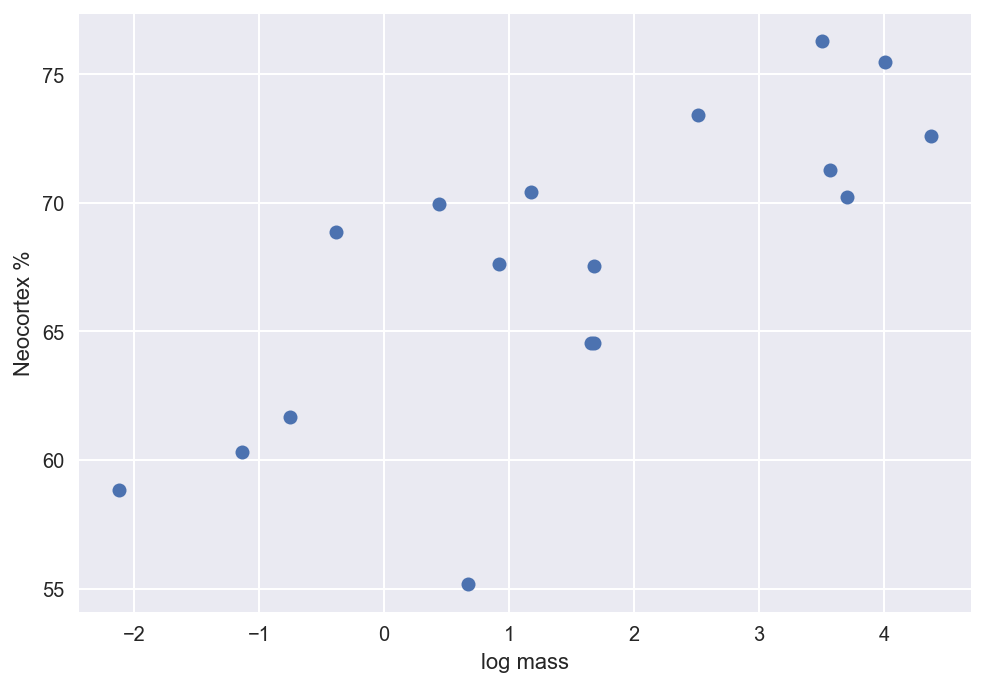

In [46]:
plt.plot(milk['log_mass'], milk['neocortex.perc'], 'o')
plt.xlabel('log mass')
plt.ylabel('Neocortex %')

***

Because these two variables are positively associated and have opposite "effects" on milk energy density, the individual effects appear to not exist in bivariate regressions.

Now let's build a multiple regression model and see how the coefficients differ:

In [47]:
with pm.Model() as m5_7:
    a = pm.Normal('a', 0, 100)
    b_n = pm.Normal('b_n', 0, 1)
    b_m = pm.Normal('b_m', 0, 1)
    sigma = pm.Uniform('sigma', 0, 1)
    mu = pm.Deterministic('mu', a + b_n * milk['neocortex.perc'] + b_m * milk['log_mass'])
    kcal = pm.Normal('kcal', mu, sigma, observed = milk['kcal.per.g'])
    m5_7_trace = pm.sample(2000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_m, b_n, a]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 9000/9000 [00:21<00:00, 425.75draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


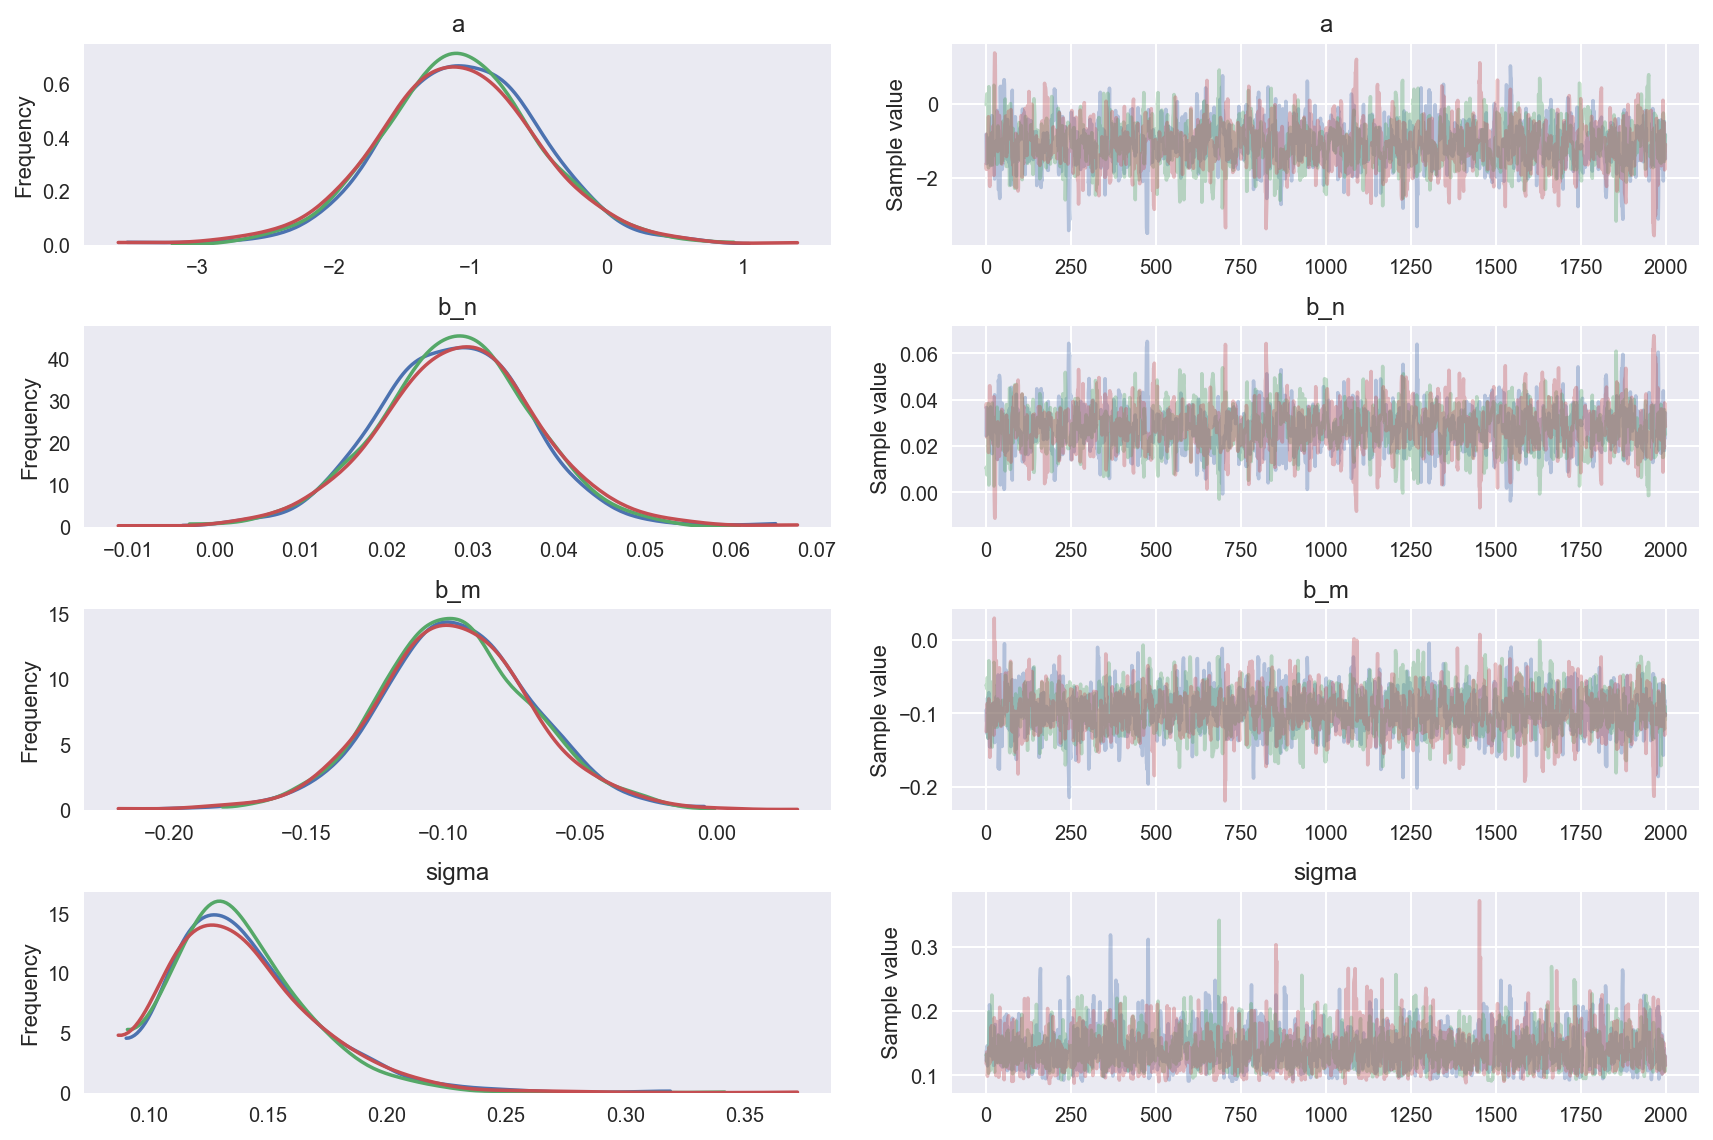

In [48]:
varnames = ['a', 'b_n', 'b_m', 'sigma']
pm.traceplot(m5_7_trace, varnames);

In [49]:
pm.summary(m5_7_trace, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a     -1.089  0.593     0.015   -2.008    -0.169  1303.067  1.000
b_n    0.028  0.009     0.000    0.013     0.041  1282.183  1.000
b_m   -0.096  0.028     0.001   -0.139    -0.051  1521.586  1.000
sigma  0.140  0.029     0.001    0.098     0.182  2052.125  1.001

By incorporating both predictors into the regression, we've increased `b_n` from 0.004 to 0.027. And its 89% hpd interval is entirely above zero. Similarly, the magnitude of `b_n` has increased from 0.032 to 0.095, and its 89% hpd interval is entirely below zero.

We can use counterfactual plots to see that the effect of each individual variable is quite strong:

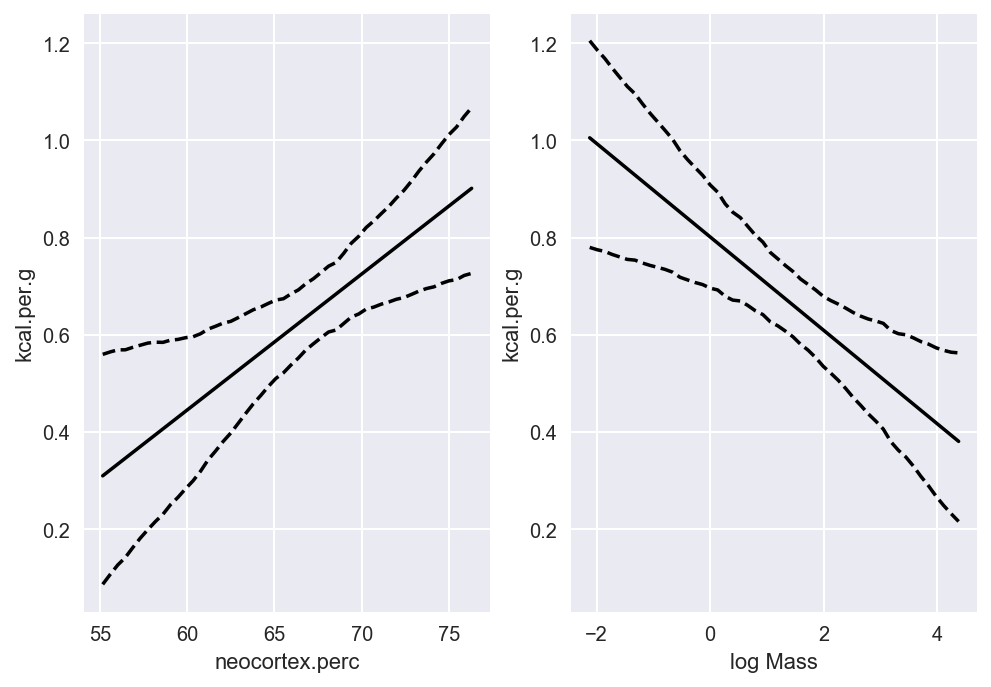

In [50]:
ax1 = plt.subplot(121)
x_space1 = np.linspace(milk['neocortex.perc'].min(), milk['neocortex.perc'].max(), 50)
mu_predicted1 = m5_7_trace['a'] + m5_7_trace['b_n'] * x_space1[:,None] + m5_7_trace['b_m'] * milk['log_mass'].mean()
mu_hpd1 = pm.hpd(mu_predicted1.T)

plt.plot(x_space1, mu_predicted1.mean(1), 'k')
plt.plot(x_space1, mu_hpd1[:,0], 'k--')
plt.plot(x_space1, mu_hpd1[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

###

ax2 = plt.subplot(122, sharey=ax1)
x_space2 = np.linspace(milk['log_mass'].min(), milk['log_mass'].max(), 50)
mu_predicted2 = m5_7_trace['a'] + m5_7_trace['b_m'] * x_space2[:,None] + m5_7_trace['b_n'] * milk['neocortex.perc'].mean()
mu_hpd2 = pm.hpd(mu_predicted2.T)

plt.plot(x_space2, mu_predicted2.mean(1), 'k')
plt.plot(x_space2, mu_hpd2[:,0], 'k--')
plt.plot(x_space2, mu_hpd2[:,1], 'k--')

plt.xlabel('log Mass')
plt.ylabel('kcal.per.g');


***


#### Why did adding the variables together lead to larger effect estimates?

Recall that the variables are positive associated with one another, and that neocortex % is positively associated with milk energy density, and body mass is negatively associated with milk energy density. The two individual effects "cancel" each other out.

However, when we include them into a multiple regression model, our model now determines if species that have a **high neocortex %** *for their body mass* have a higher milk energy density. Likewise, the model simultaneously asks if species that have a **high body mass** *for their neocortex %* have a higher milk energy density.

Because larger primates also tend to have a higher neocortex %, it is difficult to see these relationships unless we statistically account for both.

***

## 5.3 When adding variables hurts

There are many cases where adding more predictors does not improve your model. There are *many* statistical reasons not to add every predictor that you have available, but the book focuses on 3:

1. Multicollinearity

2. Post-treatment Bias

3. Overfitting

### 5.3.1 Multicollinearity

*Multicollinearity* is the phenomenon where two or more variables are *highly correlated* with one another. I.e., the two variables contain almost exactly the same information. The model is able to use either variable to fit a model, but when presented with both variables it doesn't know which one to use. The result is that the posterior distribution for the coefficient estimates is very wide.

This arises from the details of how statistical control works. Once you understand multicollinearity, you will better understand multiple regression models in general.

To explore multicollinearity, we will first turn to a simulated data set.

***

#### 5.3.1.1 Multicollinear Legs

In this example we use individuals' legs to predict their height. Surely leg length is positively associated with height, but when we include *two* legs into the model, something weird happens.

First, we'll simulate some data:

In [51]:
# Code 5.29

N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.1) 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)

Before we run the model, we should think about what we expect to see.

In this data set, the mean height is 10. Also in this simulation, an individual's legs are 45% (40 - 50%) of their height. So we would expect $\beta$ coefficients for one leg to be 10/4.5 = 2.2

Instead, when model height with 2 legs, we get:

In [52]:
with pm.Model() as m5_8:
    a = pm.Normal('a', mu=10, sd=100)
    b_l = pm.Normal('b_l', mu=2, sd=10)
    b_r = pm.Normal('b_r', mu=2, sd=10)
    mu = pm.Deterministic('mu', a + b_l * leg_left + b_r * leg_right)    
    sigma = pm.Uniform('sigma', lower=0 , upper=10)
    height_p = pm.Normal('height_p', mu=mu, sd=sigma, observed=height)
    
    m5_8_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_r, b_l, a]
Sampling 3 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [01:46<00:00, 14.33draws/s]


mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      0.972  0.301     0.007    0.490     1.447  2147.557  1.000
b_l    2.593  2.305     0.070   -1.158     6.118  1089.301  1.005
b_r   -0.587  2.307     0.070   -4.107     3.189  1093.798  1.005
sigma  0.609  0.045     0.001    0.539     0.679  1549.270  1.000

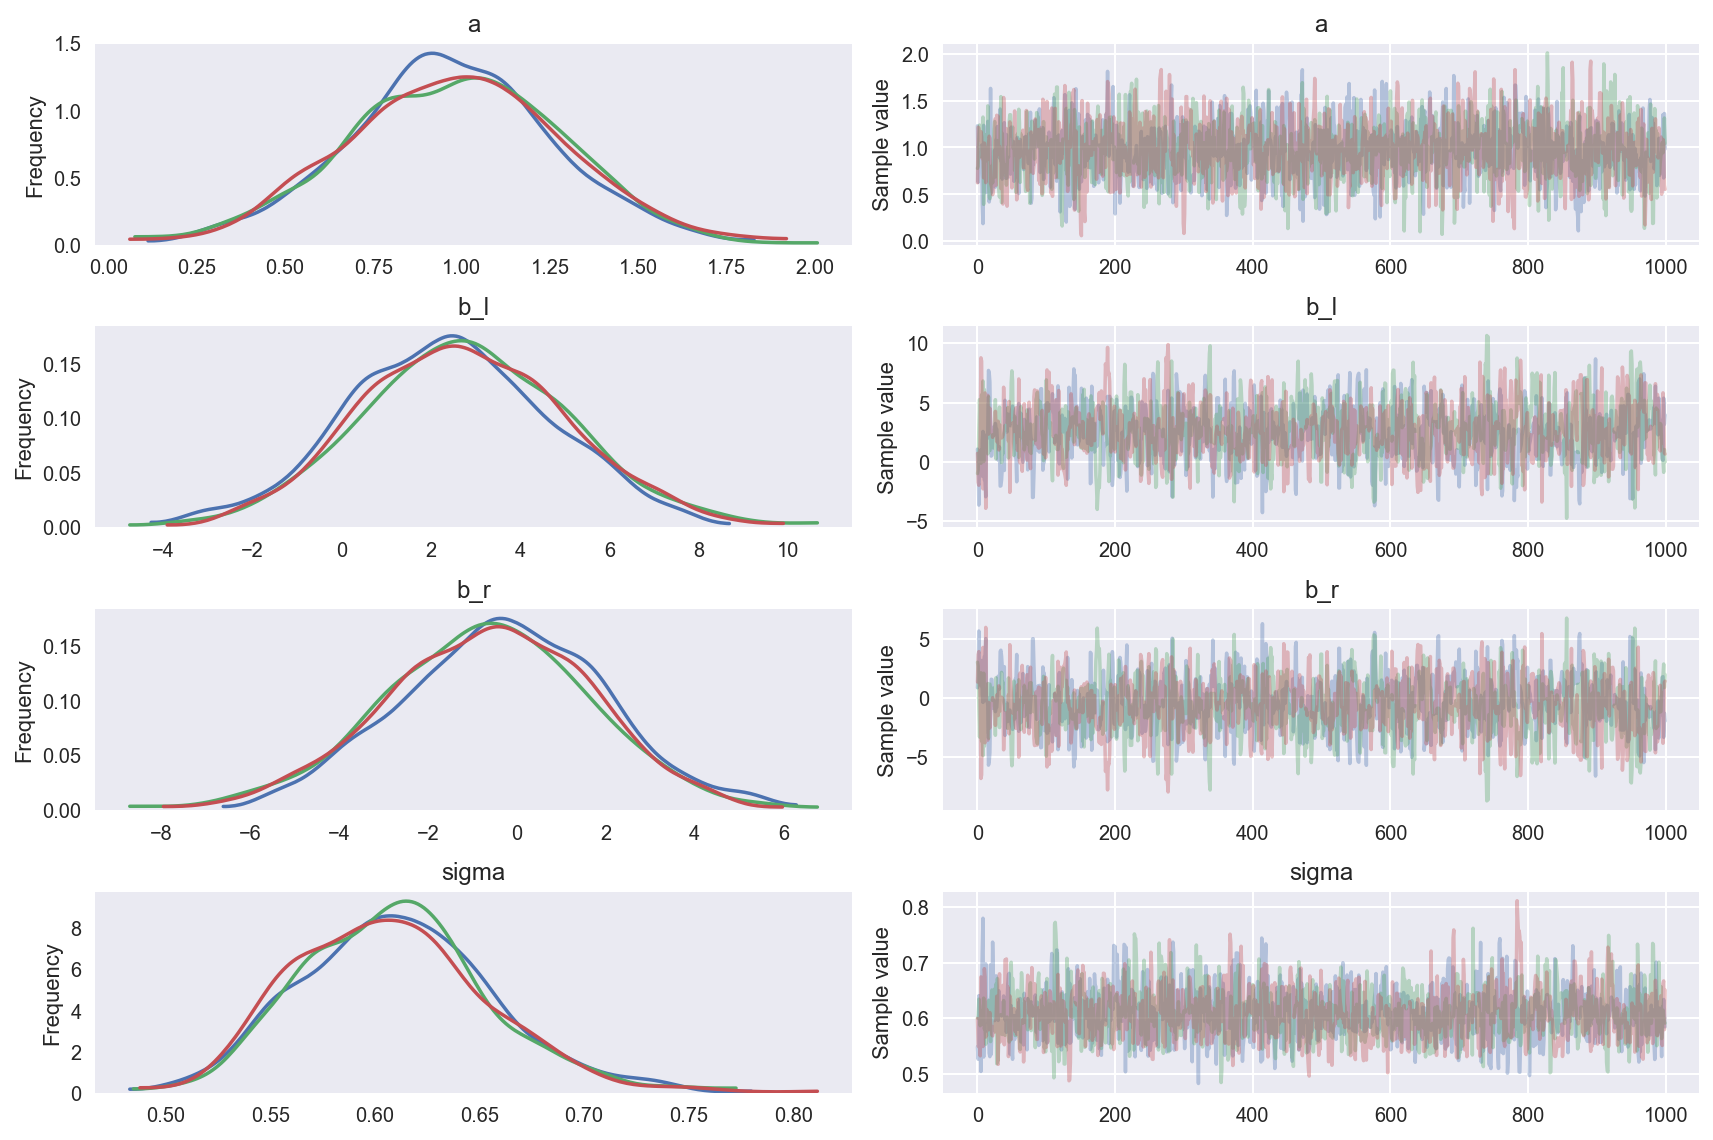

In [53]:
varnames=['a', 'b_l', 'b_r', 'sigma']
pm.traceplot(m5_8_trace, varnames);
pm.summary(m5_8_trace, varnames, alpha=.11).round(3)

***

**What do we see?**

One leg is positively associated with height, while the other is negatively associated with height. We see very larger estimates than we would expect, but also a huge amount of uncertainty. The 89% HPD intervals spanning from the negatives far into the positives. This is far from what we humans would expect, but why?

Recall that multiple linear regression answers the question: *What is the value of knowing each predictor, after already knowing each other predictor?*

The answer to this question is, correctly, the posterior distribution. The posterior has considered every possible combination of parameters and assigned relative plausibilities to each combination, conditional on this model and these data.

It helps to be able to look at the scatter plot of $\beta_l$ and $\beta_r$; they appear along a very narrow ridge. What has happened here is that since we have insisted that both legs be included in the model, there are practically an infinite number of combinations of $\beta_l$ and $\beta_r$ that produce the same predictions.

The linear equation that we specified, and are trying to solve is:

$\mu_i = \alpha + \beta_l x_{l_i} + \beta_r x_{r_i}$


However, because the right leg and left leg contain virtually all of the same information, our model contains the same $x$ value twice.  If we factor out $x$, we get:

$\mu_i = \alpha + \beta_l x_{i} + \beta_r x_{i}$

$\mu_i = \alpha + (\beta_l + \beta_r) x_{i}$

And now we can see that $\beta_l$ cannot $\beta_r$ can be teased apart, because they never influence the mean independent of one another. But... The model actually does produce a reasonable posterior if you take the **sum** of $\beta_l$ and $\beta_r$. As seen in the density plot below, the sum of the two is near two, and the standard deviation is much smaller.

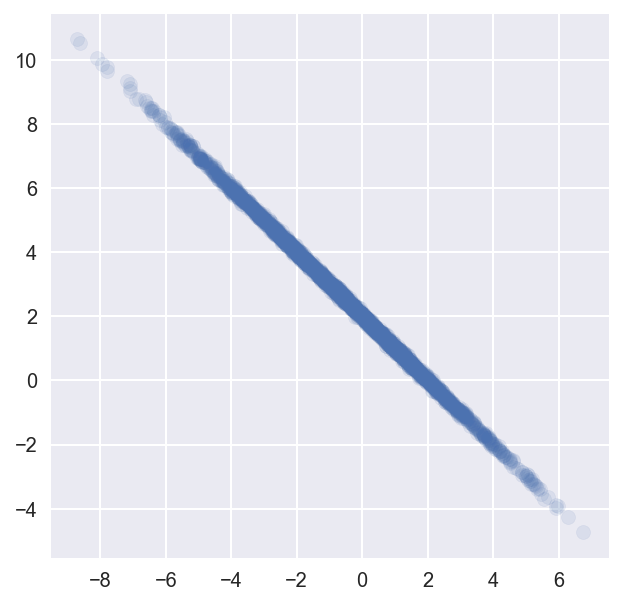

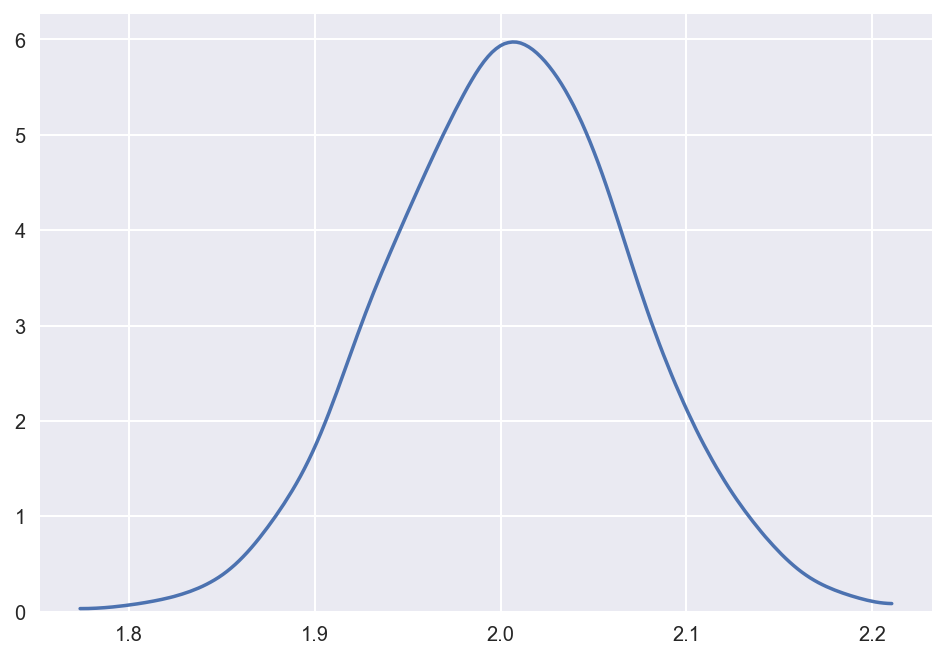

In [54]:
plt.figure(figsize=(5, 5))
plt.scatter(m5_8_trace['b_r'], m5_8_trace['b_l'], alpha=0.1)
# plt.xlabel('b_r')
# plt.xlabel('b_l')

sum_blbr = m5_8_trace['b_r'] + m5_8_trace['b_l']
pm.kdeplot(sum_blbr)
# plt.xlabel('sum of b_l and b_r');

***

#### 5.3.1.2 Multicollinear Milk

In the example with legs the issue of multicollinearity is obvious, but in real data they are not always. In the breast milk data, there are variables for `perc.fat` and `perc.lactose`. We will examine the effect of these two variables on `kcal.per.g` to explore a natural case of multicollinearity.

We will use the raw `milk` data for this.

I am skipping over a few code chunks because they are just bivariate regressions for `kcal.per.g` ~ `perc.fat` and `kcal.per.g` ~ `perc.lactose`. However, if we did run them we would see that fat is strongly positively associated with milk energy density ($\beta_f = 0.010$, $sd = 0.001$) and lactose is strongly negatively associated ($\beta_l = -0.011$, $sd = 0.001$).

Now we will run a multiple regression to see the co-efficients when both are included.

In [55]:
# Code 5.37

with pm.Model() as m5_12:
    a = pm.Normal('a',mu = 0.6, sd=10)
    b_f = pm.Normal('b_f',mu=0, sd= 1)
    b_l = pm.Normal('b_l',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + b_f * milk_raw['perc.fat'] + b_l * milk_raw['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk_raw['kcal.per.g'])
    trace5_12 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_l, b_f, a]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:12<00:00, 478.62draws/s]
The acceptance probability does not match the target. It is 0.9216479128397651, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [56]:
varnames = ['a', 'b_f', 'b_l', 'sigma']
pm.summary(trace5_12, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      1.005  0.224     0.008    0.678     1.405   618.601  1.000
b_f    0.002  0.003     0.000   -0.002     0.006   654.109  1.000
b_l   -0.009  0.003     0.000   -0.013    -0.004   621.977  1.000
sigma  0.068  0.010     0.000    0.053     0.083  1007.799  1.005

***

We see now that the co-efficients are smaller in magnitude and the standard deviations are much larger. Why?

The same phenomenon is occuring here as in the model with both legs: Fat % and Lactose % contain basically the same information. This becomes readily apparent when we plot the pairplots.

Lactose % and Fat % are almost perfectly correlated. Our model has no hope of separating information from one variable from information from the other.

Correlation: -0.9416373456839282


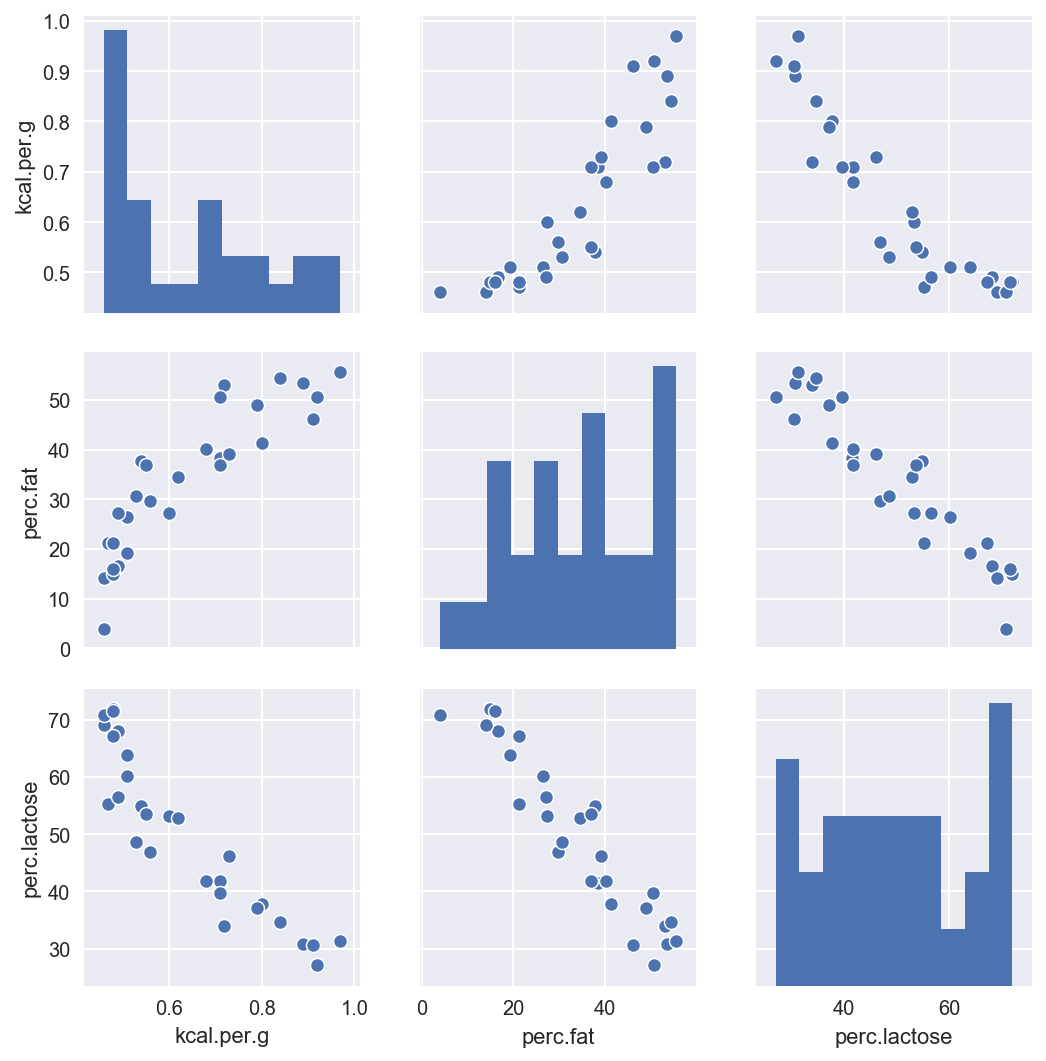

In [57]:
# Code 5.38-39
print('Correlation: ' + str(milk_raw.corr()['perc.fat']['perc.lactose']))
sns.pairplot(milk_raw[['kcal.per.g','perc.fat','perc.lactose']]);

***

#### 5.3.1.3 Dealing with Multicollinearity


##### When to Worry

How  strong do correlations have to get before you should start to worry about multicollinearity? There's no straightforward answer, but in general pretty high.

And what matters isn't just the correlation between two predictors, rather it is the correlation that remains after accounting for other predictors. It is possible that adding other predictors will decorrelate the variables because there may be some information in one predictor than the other. It is also possible that more than two variables are multicollinear on each other.

In **this example**, we can simulate a variable with different degrees of correlation to `perc.fat`. Then, by fitting some models we can estimate and plot the standard deviation of the $\beta_f$ parameter vs. correltion. 

One useful way to **diagnose multicollinearity** is by looking to see if the standard deviation of a predictor becomes inflated when the suspected predictor is added.

In this example the standard deviation doesn't become inflated until 
$\rho = 0.9$, though pairwise correlations will not always tell you how big your risk of multicollinearity is.

<img src="Images/Ch5_fig5.10.png" width="600" height="285">

##### How to Handle

Multicollinearity is handled in many different ways--different fields may have different conventions. The main way to handle multicollinearity is simply to be aware of it.

Dimension reduction methods like PCA and Factor Analysis can reduce the problem of multicollinearity, at the cost of interpretability.

Another strategy is to demonstrate that using any of the multicolinnear predictors in a model will produce the same result. E.g., to demonstrate that using either the left or the right leg produces a model with similar results.

Multicollinearity belongs to a family of model-fitting problems known as *Non-Identifiability*. This problem arises when the structure of the data and the model do not make it possible to estimate the paramter's value.

***

### 5.3.3 Post-Treatment Bias

Scientists often worry about excluding predictors that may have an effect on the outcome, known as *Omitted Variable Bias*. It is much less common that scientists worry about including a predictor that is downstream of the treatment effect, thus introducing *Post-Treatment Bias*.

We will use an example of an experiment where we treat plants with fungicide to increase their growth. The fungicide itself does not increase plant growth, but it inhibits the growth of fungus and thus allows the plant to grow. If we include presence/absence of fungus in the soil as a predictor, we will fail to see any effect of the fungicide on growth. Because the fungicide is a *post-treatment effect* it **better accounts for the variability** in plant growth than the treatment itself.

Other common examples come from the social sciences. If we are interested in modeling *current income* on *socioeconomic_status_at_birth*, but include *occupation* in the model, socioeconomic status will count for nothing since occupation better explains variability in income.

***

In the code cell below we run a simulation of the plant example. We are using a simulation because it lets us see the exact data generation process, so we know for certain that there is a real effect of the fungicide treatment.

We also include in the model `h0` *initial height*; this is a great example of a pre-treatment effect that *should* be controlled-for.

In [58]:
# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(size = N, loc = 10, scale = 2)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment * 0.4), size=N)
h1 = h0 + stats.norm.rvs(size= N, loc= 5- 3*fungus, scale=1)

# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'treatment':treatment,
                  'fungus': fungus})

Now we fit a model with all of the variables:

In [59]:
#Code 5.41
with pm.Model() as m5_13:
    a = pm.Normal('a', 0, 100)
    b_h = pm.Normal('b_h', 0, 10)
    b_t = pm.Normal('b_t', 0, 10)
    b_f = pm.Normal('b_f', 0, 10)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', a + b_h * d['h0'] + b_t * d['treatment'] + b_f * d['fungus'])
    h1 = pm.Normal('h1', mu, sigma, observed=d['h1'])
    
    trace5_13 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_f, b_t, b_h, a]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 841.80draws/s]


In [60]:
varnames = ['a', 'b_h', 'b_t', 'b_f', 'sigma']
pm.summary(trace5_13, varnames, alpha=0.11)

mean        sd  mc_error   hpd_5.5  hpd_94.5        n_eff      Rhat
a      4.659345  0.478551  0.012773  3.931525  5.458145  1283.709192  0.999794
b_h    0.985173  0.043541  0.001049  0.914055  1.054092  1504.240880  0.999788
b_t    0.759530  0.209483  0.005096  0.427785  1.085214  1692.394096  1.000706
b_f   -2.536329  0.218541  0.005819 -2.892524 -2.197954  1807.286687  1.000106
sigma  0.946039  0.067010  0.001336  0.843219  1.051243  2125.331904  0.999912

We see from the table that the effect of $\beta_t$ is rather small with a large proportion of its posterior probability in the negative. If we were to just look at this table we might conclude that there was no effect of the treatment.

However, because this is an experiment we know that presence of fungus is a post-treatment effect. We can just exclude this predictor from the model. In observational studies this is not so simple.

In [61]:
#Code 5.43
with pm.Model() as m5_14:
    a = pm.Normal('a', 0, 100)
    b_h = pm.Normal('b_h', 0, 10)
    b_t = pm.Normal('b_t', 0, 10)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', a + b_h * d['h0'] + b_t * d['treatment'])
    h1 = pm.Normal('h1', mu, sigma, observed=d['h1'])
    
    trace5_14 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_t, b_h, a]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 986.45draws/s]


In [62]:
varnames = ['a', 'b_h', 'b_t', 'sigma']
pm.summary(trace5_14, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      3.375  0.748     0.022    2.173     4.554  1104.381   1.0
b_h    0.982  0.070     0.002    0.875     1.097  1146.956   1.0
b_t    1.680  0.301     0.007    1.157     2.131  1954.223   1.0
sigma  1.475  0.106     0.002    1.303     1.636  2129.647   1.0

The treatment effect is now parge and quite positive, as expected given that we generated the data.

***

## 5.4 Categorical Variables

As I am already pretty familiar with how categorial variables are incorporated into regression models, this section will be abridged.


In [63]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

We can specify a model for $height ~ male$, where `male` is assigned 1 if male and 0 if female. as follows:

$$h_i \sim Normal(\mu_i, \sigma)$$

$$\mu_i = \alpha + \beta_m * x_i$$

$$\sigma \sim Uniform(0, 50)$$

$$\beta_m \sim Normal(0, 10)$$

$$\alpha \sim Normal(178, 100)$$


In [64]:
# Code 5.45

with pm.Model() as m5_15:
    a = pm.Normal('a', 178, 100)
    b_m = pm.Normal('b_m', 0, 10)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', a + b_m * d['male'])
    height = pm.Normal('height', mu, sigma, observed=d['height'])
    
    trace5_15 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_m, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1591.48draws/s]


In [65]:
varnames = ['a', 'b_m', 'sigma']
pm.summary(trace5_15, varnames, alpha=0.11)

mean        sd  mc_error     hpd_5.5    hpd_94.5        n_eff  \
a      134.804893  1.595629  0.037286  132.432560  137.455077  1900.663193   
b_m      7.322733  2.310724  0.054649    3.564919   10.841393  1783.299699   
sigma   27.440304  0.846515  0.018351   26.124281   28.847970  2168.288691   

           Rhat  
a      0.999719  
b_m    0.999635  
sigma  0.999629

$\alpha$ will correspond to the mean female height in our model output because when $x_male = 0$, $\mu = \alpha + \beta_m * 0 = \alpha$.

$\beta_m$ will tell us the difference between the between male and female height. Thus $\alpha + \beta_m$ = mean male height.

However, it is not enough to just know the parameter means and SDs. For example, to  construct the posterior for male height we cannot simply add the boundaries for $\alpha$ and $\beta_m$ because they are correlated. Instead, we sample $\alpha$ and $\beta_m$ together to get the posterior distribution of their sum.

[139.42181498 144.71418356]


C:\Users\alexa\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


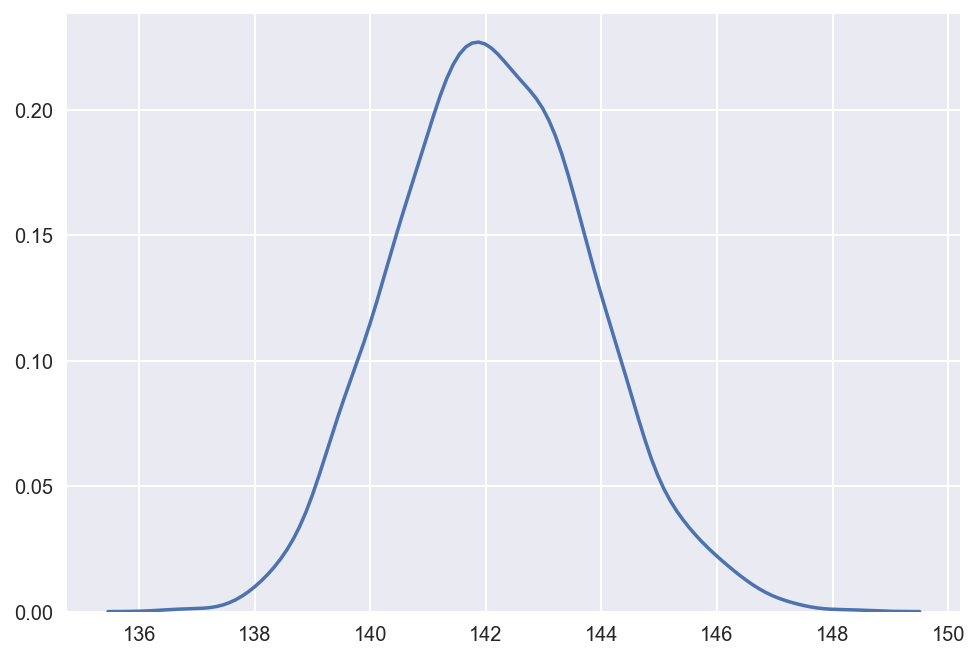

In [66]:
mu.male = trace5_15['a'] + trace5_15['b_m']
print(pm.hpd(mu.male, alpha=0.11))
sns.kdeplot(mu.male);

***

##### Categorical Variables with Multiple Levels


In [67]:
milk_raw = pd.read_csv('Data/milk.csv', sep=';')
milk = milk_raw


Adding a categorical variable with multiple levels seems to be more involved. I haven't found an easy way to do this in PyMC3.

In the example below I am examining the effect of `clade` on `kcal.per.g`. `clade` consists of 4 levels.

In [68]:
# Note: As of August 2018 this is the way we're "supposed" to assign pd dataframes
milk = milk.assign(clade_id = pd.Categorical(milk.loc[:, 'clade']).codes)

In [69]:
# Reference table for `clade` -> `clade_id` (Is there an easier way?)
milk.loc[:, ['clade', 'clade_id']].drop_duplicates()

clade  clade_id
0      Strepsirrhine         3
5   New World Monkey         1
14  Old World Monkey         2
20               Ape         0

In [70]:
with pm.Model() as m5_16:
    a = pm.Normal('a', 0.6, 10)
    # You can create multiple beta variables by setting the `shape` parameter equal to the number of levels in the variable.
    b = pm.Normal('b', 0, 10, shape=len(milk['clade_id'].unique()))
    sigma = pm.Uniform('sigma', 0, 10)
    # Treat beta as a dataframe, and index it by the values in `clade_id
    # Note for this step `clade_id` must be an integer; PyMC3 does not automatically convert categorical variables to integers.
    mu = pm.Deterministic('mu', a + b[milk['clade_id'].values] * milk['clade_id'])
    kcal_per_g = pm.Normal('kcal_per_g', mu, sigma, observed = milk['kcal.per.g'])
    
    trace5_16 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1156.60draws/s]


In [71]:
varnames = ['a', 'b', 'sigma']
pm.summary(trace5_16, varnames, alpha=.11)

mean         sd  mc_error    hpd_5.5   hpd_94.5        n_eff  \
a      0.546419   0.043202  0.001021   0.481600   0.618676  1611.421217   
b__0   0.193165  10.072849  0.207137 -15.055074  16.951136  2878.264533   
b__1   0.168234   0.061001  0.001528   0.072957   0.262934  1672.172209   
b__2   0.120543   0.034113  0.000760   0.063055   0.171784  1831.101947   
b__3  -0.012906   0.024903  0.000563  -0.053316   0.023334  1906.618415   
sigma  0.130017   0.019794  0.000445   0.098678   0.157043  2220.589444   

           Rhat  
a      1.000055  
b__0   1.000064  
b__1   1.000166  
b__2   0.999641  
b__3   1.000199  
sigma  1.001231

***

Another way is to repeat the same process above, but estimate multiple $\alpha$ parameters instead of $\beta$. This produces the same result but you estimate the mean within each group directly. However, I believe you can only interpret these $\alpha$ values when that categorical variable is the variable in the model.

In [72]:
with pm.Model() as m5_16_alt:
    a = pm.Normal('a', mu = 0.6, sd=10,
    shape=len(milk['clade_id'].unique()))
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    mu = pm.Deterministic('mu', a[milk['clade_id'].values])
    kcal_per_g = pm.Normal('kcal_per_g', mu, sigma, observed = milk['kcal.per.g'])
    
    trace5_16_alt = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1355.23draws/s]


In [73]:
varnames = ['a', 'sigma']
pm.summary(trace5_16_alt, varnames, alpha=.11)

mean        sd  mc_error   hpd_5.5  hpd_94.5        n_eff      Rhat
a__0   0.545513  0.043930  0.000747  0.476609  0.614254  3126.423747  1.000210
a__1   0.714865  0.043491  0.000719  0.645309  0.782981  3668.507179  0.999696
a__2   0.786986  0.052285  0.000886  0.701145  0.865315  3100.033869  1.000029
a__3   0.507011  0.059375  0.001015  0.410370  0.599696  2911.750926  0.999988
sigma  0.129920  0.019052  0.000304  0.102160  0.160048  2689.103398  0.999705

***

# Exercises

## Easy


**5E1.** Which of the linear models below are multiple linear regressions?

(1) $\mu_i = \alpha + \beta x_i$

(2) $\mu_i = \beta_x x_i +  \beta_z z_i$

(3) $\mu_i = \alpha + \beta(x_i + z_i)$

(4) $\mu_i = \alpha + \beta_x x_i + \beta_z z_i)$


(1) is a bivariate model. (2) is a multiple linear model with no intercept. (3) is a multiple linear model where x and z are perfectly correlated. (4) is a multiple linear model.

**5E2.** 5E2. Write down a multiple regression to evaluate the claim: Animal diversity is linearly related to latitude, but only afer controlling for plant diversity. You just need to write down the model defnition.

$$d_i = \alpha + \beta_l x_{l_i} + \beta_p x_{p_i}$$


**5E3.** Write down a multiple regression to evaluate the claim: Neither amount of funding nor size of laboratory is by itself a good predictor of time to PhD degree; but together these variables are both positively associated with time to degree. Write down the model defnition and indicate which side of zero each slope parameter should be on.

$$t_i = \alpha + \beta_{size_i} x_{size_i} + \beta_{funding} x_{funding_i}$$

Size and funding may be negatively correlated with each other, but positively associated with time to PhD completion..?

**5E4.** Suppose you have a single categorical predictor with 4 levels (unique values), labeled A, B, C and D. Let Ai be an indicator variable that is 1 where case i is in category A. Also suppose Bi, Ci, and Di for the other categories. Now which of the following linear models are inferentially equivalent ways to include the categorical variable in a regression? Models are inferentially equivalent when it’s
possible to compute one posterior distribution from the posterior distribution of another model.

(2) $\mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_C C_i + \beta_D D_i$

(4) $\mu_i = \alpha_A A_i + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i$

are inferentially equivalent

***

## Medium

**5M1.** Invent your own example of a spurious correlation. An outcome variable should be correlated with both predictor variables. But when both predictors are entered in the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced)

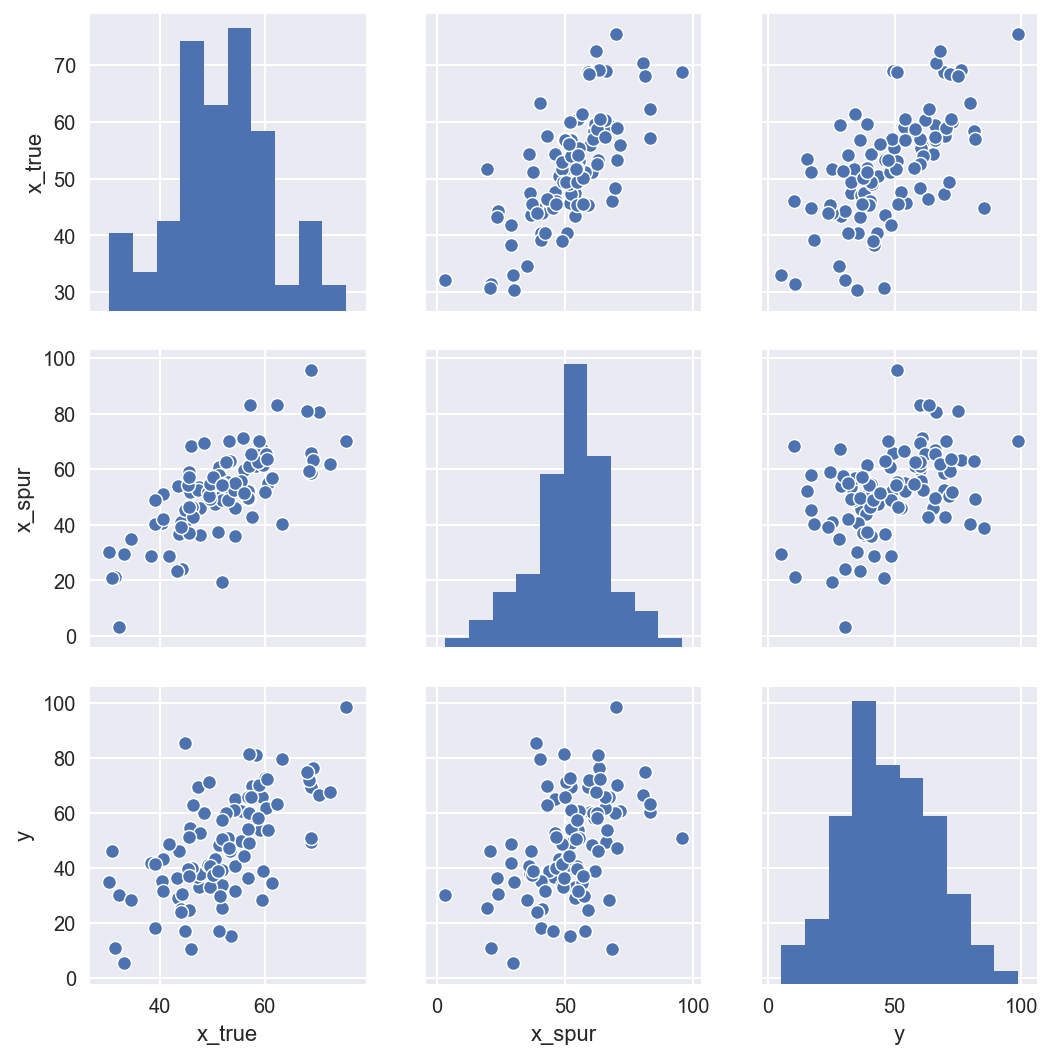

In [74]:
x_true = stats.norm.rvs(50, 10, 100)
x_spur = stats.norm.rvs(x_true, 10, 100)
y = stats.norm.rvs(x_true, 15, 100)

dat = pd.DataFrame({'x_true':x_true, 'x_spur': x_spur, 'y': y})

sns.pairplot(dat);

I'm too lazy to run a bunch of bivariate models so just believe from the plots that the bivariate associations are there.

Model for the multiple linear regression:

In [75]:
with pm.Model() as M1:
    a = pm.Normal('a', 50, 20)
    b_xtrue = pm.Normal('b_xtrue', 0, 1)
    b_xspur = pm.Normal('b_xspur', 0, 1)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = a + b_xtrue * dat['x_true'] + b_xspur * dat['x_spur']
    y = pm.Normal('y', mu, sigma, observed = dat['y'])
    
    trace_M1 = pm.sample(500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_xspur, b_xtrue, a]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 552.59draws/s]


In [76]:
pm.summary(trace_M1)

mean        sd  mc_error    hpd_2.5   hpd_97.5       n_eff  \
a        -4.573995  7.839423  0.262025 -19.788813  10.130721  742.024342   
b_xtrue   1.054494  0.213204  0.008227   0.674414   1.495977  646.970561   
b_xspur  -0.033864  0.139542  0.005643  -0.292580   0.240506  649.794612   
sigma    14.757430  1.047418  0.035496  12.808033  16.793528  854.973194   

             Rhat  
a        0.999999  
b_xtrue  1.000436  
b_xspur  1.004065  
sigma    1.001728

***

**5M2.** Invent your own example of a masked relationship. An outcome variable should be correlated with both predictor variables, but in opposite directions. And the two predictor variables should be correlated with one another.



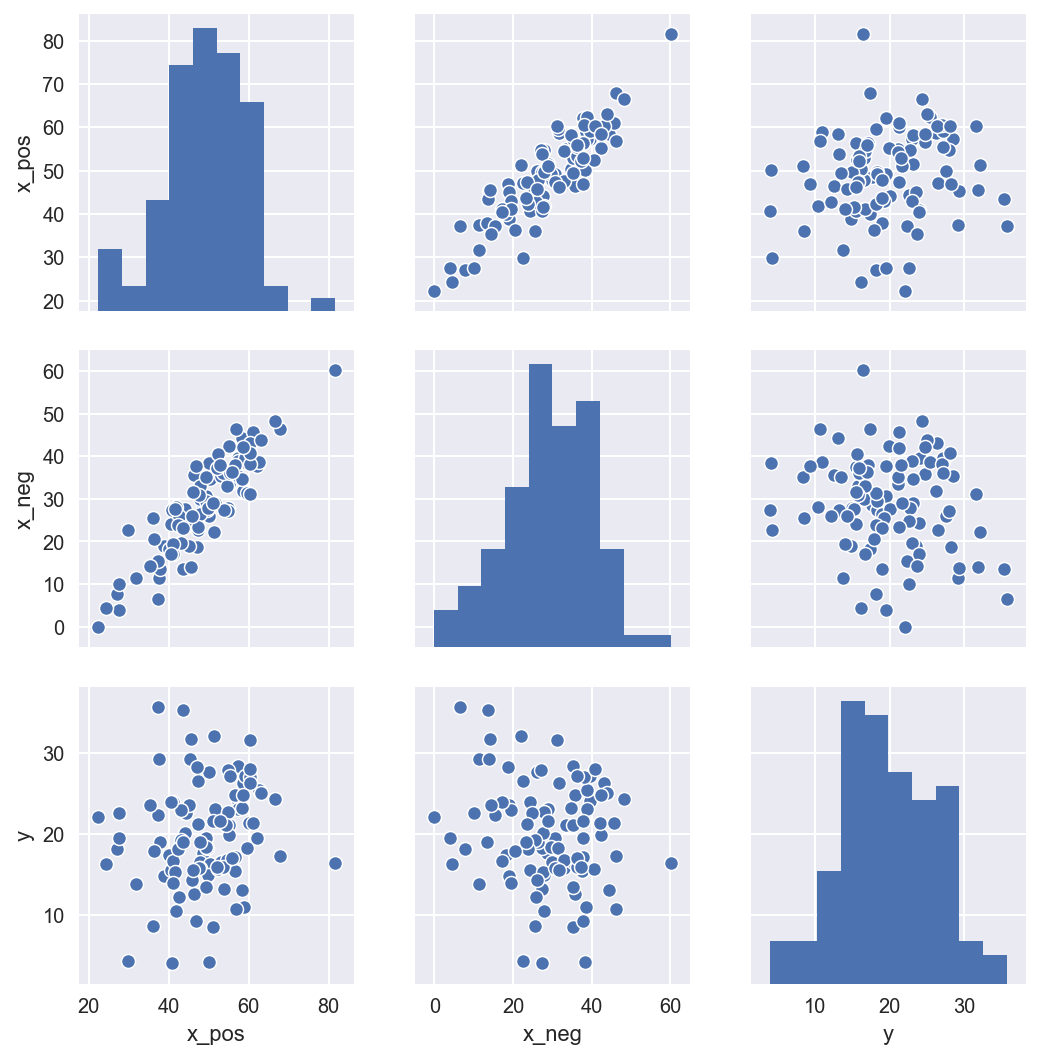

In [77]:
x_pos = stats.norm.rvs(50, 10, 100)
x_neg = x_pos - stats.norm.rvs(20, 5, 100)
y = stats.norm.rvs(x_pos - x_neg, 5, 100)

dat = pd.DataFrame({'x_pos':x_pos, 'x_neg': x_neg, 'y': y})

sns.pairplot(dat);

In [78]:
with pm.Model() as M2:
    a = pm.Normal('a', 50, 20)
    b_xpos = pm.Normal('b_pos', 0, 1)
    b_xneg = pm.Normal('b_neg', 0, 1)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = a + b_xpos * dat['x_pos'] + b_xneg * dat['x_neg']
    y = pm.Normal('y', mu, sigma, observed = dat['y'])
    
    trace_M2 = pm.sample(500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_neg, b_pos, a]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 530.88draws/s]
The acceptance probability does not match the target. It is 0.8819963434968544, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9146887917240946, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [79]:
pm.summary(trace_M2)

mean        sd  mc_error   hpd_2.5  hpd_97.5       n_eff      Rhat
a     -0.925758  2.854497  0.129176 -6.290321  4.661725  293.327540  1.001587
b_pos  0.932290  0.101557  0.005060  0.739466  1.129940  242.621997  1.004287
b_neg -0.857321  0.094533  0.004382 -1.037255 -0.666963  304.601436  1.005238
sigma  4.589884  0.337682  0.012486  4.038822  5.337483  634.404303  1.000690

***

**5M3.** It is sometimes observed that the best predictor of fre risk is the presence of frefghters—States and localities with many frefghters also have more fres. Presumably frefghters do not cause fres. Nevertheless, this is not a spurious correlation. Instead fres cause frefghters. Consider the same reversal of causal inference in the context of the divorce and marriage data. How might a high divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship, using multiple regression?

Higher divorce rates may lead to more opportunities to remarry, thus increasing the marriage rate. If available, you could include another predictor like "rate of second+ marriage" or "rate of first marriage".

**5M4.** In the divorce data, States with high numbers of Mormons (members of The Church of Jesus Christ of Latter-day Saints, LDS) have much lower divorce rates than the regression models expected. Find a list of LDS population by State and use those numbers as a predictor variable, predicting divorce rate using marriage rate, median age at marriage, and percent LDS population (possibly standardized). You may want to consider transformations of the raw percent LDS variable.

In [80]:
int('10')

10

In [81]:
dat_divorce = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# Data from wikipedia
dat_LDS = pd.read_csv('Data/LDS_population.csv')

# Clean up the LDS variable
dat_LDS['LDS'] = dat_LDS['LDS'].str.split('%').str[0]
dat_LDS['LDS'] = dat_LDS['LDS'].astype('float')

# Join the data sets on state
dat_divorce = pd.merge(dat_divorce, dat_LDS, left_on='Location', right_on='State')

In [82]:
dat_divorce.sort_values('LDS', ascending=False).head()

Location Loc  Population_x  MedianAgeMarriage  Marriage  Marriage SE  \
43     Utah  UT          2.76               23.3      29.6         1.77   
12    Idaho  ID          1.57               23.2      25.8         1.84   
49  Wyoming  WY          0.56               24.2      30.7         3.92   
2   Arizona  AZ          6.33               25.8      20.3         0.98   
11   Hawaii  HI          1.36               26.9      24.9         2.54   

    Divorce  Divorce SE  WaffleHouses  South          ...            \
43     10.2        0.93             0      0          ...             
12      7.7        1.05             0      0          ...             
49     10.3        1.90             0      0          ...             
2      10.8        0.74            18      0          ...             
11      8.3        1.27             0      0          ...             

    Population1860  PropSlaves1860    State Membership Population_y    LDS  \
43           40273             0.0     Utah  2,090,401    3,101,833  67.39   
12               0             0.0    Idaho    450,347    1,716,943  26.23   
49               0             0.0  Wyoming     67,275      579,315  11.61   
2                0             0.0  Arizona    428,069    7,016,270   6.10   
11               0             0.0   Hawaii     74,278    1,427,538   5.20   

    Temples  Missions  Congregations Family History Centers  
43     17.0      11.0          5,110                  170.0  
12      5.0       4.0          1,126                   70.0  
49      1.0       1.0            167                   46.0  
2       6.0       6.0            895                   74.0  
11      2.0       1.0            141                   26.0  

[5 rows x 21 columns]

In [83]:
# Not bothering to standardize the variables. Going to decide on some rough priors.

with pm.Model() as m5m4:
    a = pm.Normal('a', 0, 100)
    b_rate = pm.Normal('b_rate', 0, 10)
    b_age = pm.Normal('b_age', 0, 10)
    b_lds = pm.Normal('b_lds', 0, 10)
    mu = pm.Deterministic('mu', 
                          a 
                          + b_rate * dat_divorce['Marriage'] 
                          + b_age * dat_divorce['MedianAgeMarriage']
                          + b_lds * dat_divorce['LDS']
                         )
    sigma = pm.Uniform('sigma', 0, 50)
    divorce = pm.Normal('divorce', mu, sigma, observed = dat_divorce['Divorce'])
    
    trace = pm.sample(500, tune=200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_lds, b_age, b_rate, a]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 2100/2100 [00:10<00:00, 208.10draws/s]
The acceptance probability does not match the target. It is 0.9133454756481829, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8839204123984777, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9158943031368895, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


***

Now assess model performance...

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B30782EB70>,
      dtype=object)

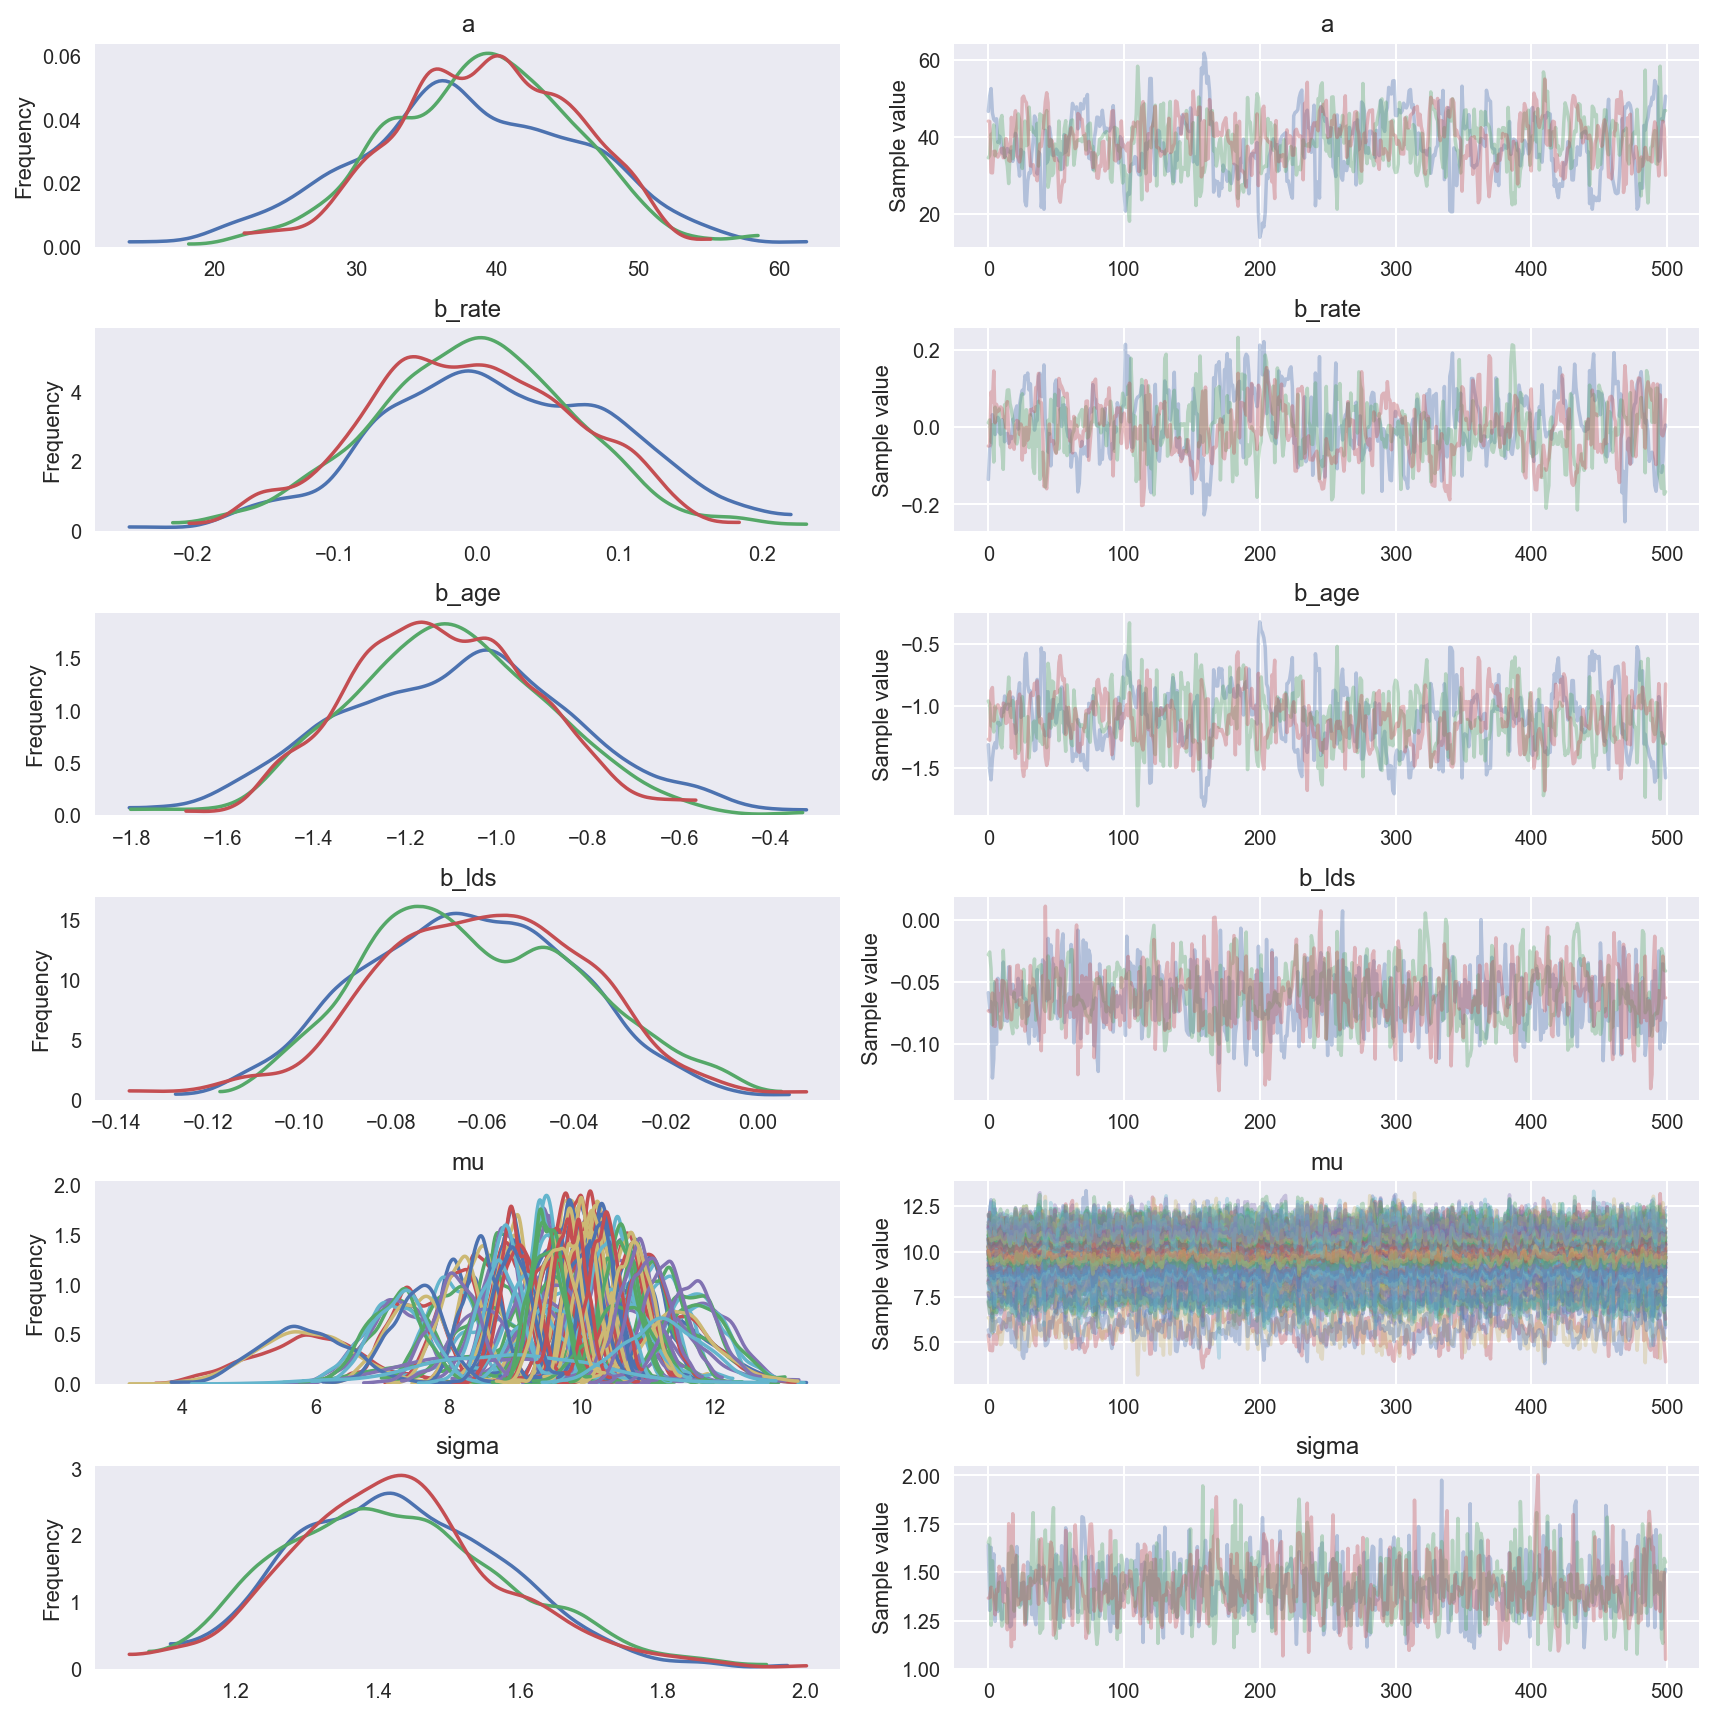

In [84]:
pm.traceplot(trace)

In [88]:
# Copied Code 5.14

mu_predicted = trace['mu']
mu_hpd = pm.hpd(mu_predicted, alpha=0.1).T

# Compute residuals of observed vs. predicted means
residuals = dat_divorce['Divorce'] - mu_predicted.mean(0)
idx = np.argsort(residuals)

# Sample from the posterior to construct prediction intervals
divorce_predictions = pm.sample_ppc(trace, samples=500, model=m5m4)['divorce']
divorce_hpd = pm.hpd(divorce_predictions, alpha=0.1).T

C:\Users\alexa\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  # This is added back by InteractiveShellApp.init_path()
100%|████████████████████████████████| 500/500 [00:00<00:00, 2695.15it/s]


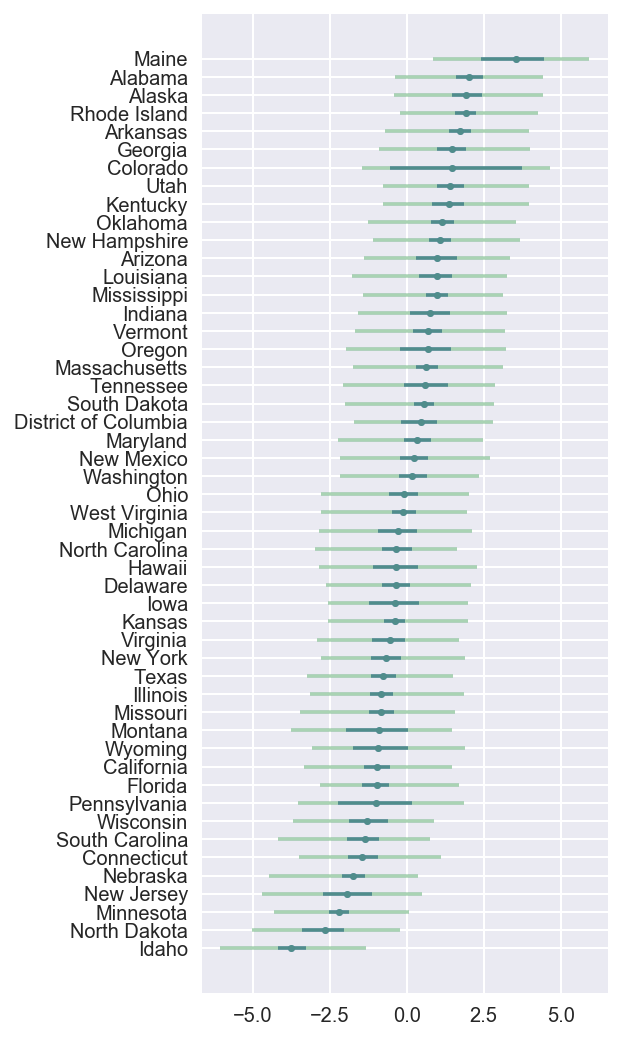

In [99]:
plt.figure(figsize=(8, 9))
# Mean + Credible Interval
plt.subplot(121)
plt.errorbar(residuals[idx],
            dat_divorce['Location'][idx],    # Sort States by residuals
            xerr=np.abs(mu_predicted.mean(0)-mu_hpd),
             marker='.',
            linestyle='')

# Prediction Interval
plt.errorbar(residuals[idx],
            dat_divorce['Location'][idx],    # Sort States by residuals
            xerr=np.abs(mu_predicted.mean(0)-divorce_hpd),
             marker='.',
            linestyle='',
            alpha=0.5);

***

The addition of LDS didn't seem to affect the model tremendously. The prediction for Utah became more accurate, but the model still somewhat underestimates other LDS states like Idaho and Wyoming.


***

**5M5.** One way to reason through multiple causation hypotheses is to imagine detailed mechanisms through which predictor variables may inﬂuence outcomes. For example, it is sometimes argued that the price of gasoline (predictor variable) is positively associated with lower obesity rates (outcome variable). However, there are at least two important mechanisms by which the price of gas could reduce obesity. First, it could lead to less driving and therefore more exercise. Second, it could lead to less driving, which leads to less eating out, which leads to less consumption of huge restaurant meals. Can you outline one or more multiple regressions that address these two mechanisms? Assume you can have any predictor data you need.

For the hypothesis that increased gas prices lead to less driving which leads to decreased obesity via exercise: You could construct a model of:

(1) `obesity ~ gasoline_price`

(2) `obesity ~ driving + gasoline_price`

(3) `obesity ~ driving + exercise + gasoline_price`

As we expect these to be post-treatment effects, we should see the effect of each variable decrease with the addition of the new downstream predictor.

Or you could do:

(1) `obesity ~ gasoline_price`

(2) `driving ~ gasoline_price`

(3) `exercise ~ driving`

(4) `obesity ~ exercise`

***

## Hard

All three exercises below use the same data, data(foxes) (part of rethinking). The urban fox (Vulpes vulpes) is a successful exploiter of human habitat. Since urban foxes move in packs and defend territories, data on habitat quality and population density is also included. The data frame has five columns:

(1) group: Number of the social group the individual fox belongs to

(2) avgfood: The average amount of food available in the territory

(3) groupsize: The number of foxes in the social group

(4) area: Size of the territory

(5) weight: Body weight of the individual fox

In [112]:
foxes = pd.read_csv('Data/foxes.csv', sep=';')

print(foxes.shape)
foxes.head()

(116, 5)


group  avgfood  groupsize  area  weight
0      1     0.37          2  1.09    5.02
1      1     0.37          2  1.09    2.84
2      2     0.53          2  2.05    5.33
3      2     0.53          2  2.05    6.07
4      3     0.49          2  2.12    5.85

**5H1.** Fit two bivariate Gaussian regressions: (1) body weight as a linear function of territory size (area), and (2) body weight as a linear function of groupsize. Plot the results of these regressions, displaying the MAP regression line and the 95% interval of the mean. Is either variable
important for predicting fox body weight?

In [113]:
# Territory size (area):
with pm.Model() as m5h1a:
    a = pm.Normal('a', 5, 3)    # Weak prior for mean weight of 5kg
    b_a = pm.Normal('b_a', 0, 3)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', a + b_a * foxes['area'])
    weight = pm.Normal('weight', mu, sigma, observed=foxes['weight'])
    
    trace_m5h1a = pm.sample(500, tune=200)
    
# group size:

with pm.Model() as m5h1b:
    a = pm.Normal('a', 5, 3)    # Weak prior for mean weight of 5kg
    b_g = pm.Normal('b_g', 0, 3)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', a + b_g * foxes['groupsize'])
    weight = pm.Normal('weight', mu, sigma, observed=foxes['weight'])
    
    trace_m5h1b = pm.sample(500, tune=200)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_a, a]
Sampling 3 chains: 100%|█████████| 2100/2100 [00:02<00:00, 714.91draws/s]
The acceptance probability does not match the target. It is 0.9301293052336259, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9191757575556517, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9295552441025772, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_g, a]
Sampling 3 chains: 100%|█████████| 2100/2100 [00:03<00:00, 652.76draws/s]
The acceptance probability does not match

In [123]:
print(pm.summary(trace_m5h1a, ['a', 'b_a', 'sigma'], alpha=0.11))

print(pm.summary(trace_m5h1b, ['a', 'b_g', 'sigma'], alpha=0.11))

# pm.traceplot(trace_m5h1a);
# pm.traceplot(trace_m5h1b);

           mean        sd  mc_error   hpd_5.5  hpd_94.5        n_eff      Rhat
a      4.494319  0.398886  0.020663  3.879430  5.116712   341.135850  1.005716
b_a    0.012477  0.120203  0.006189 -0.166675  0.198617   347.850868  1.006663
sigma  1.204046  0.081729  0.002177  1.081563  1.336676  1250.107760  0.999060
           mean        sd  mc_error   hpd_5.5  hpd_94.5        n_eff      Rhat
a      5.075025  0.328454  0.017172  4.523755  5.565076   271.510079  1.001104
b_g   -0.125953  0.070581  0.003620 -0.243676 -0.019863   282.071248  1.001130
sigma  1.186037  0.081211  0.002016  1.057583  1.308904  1749.324507  1.000153


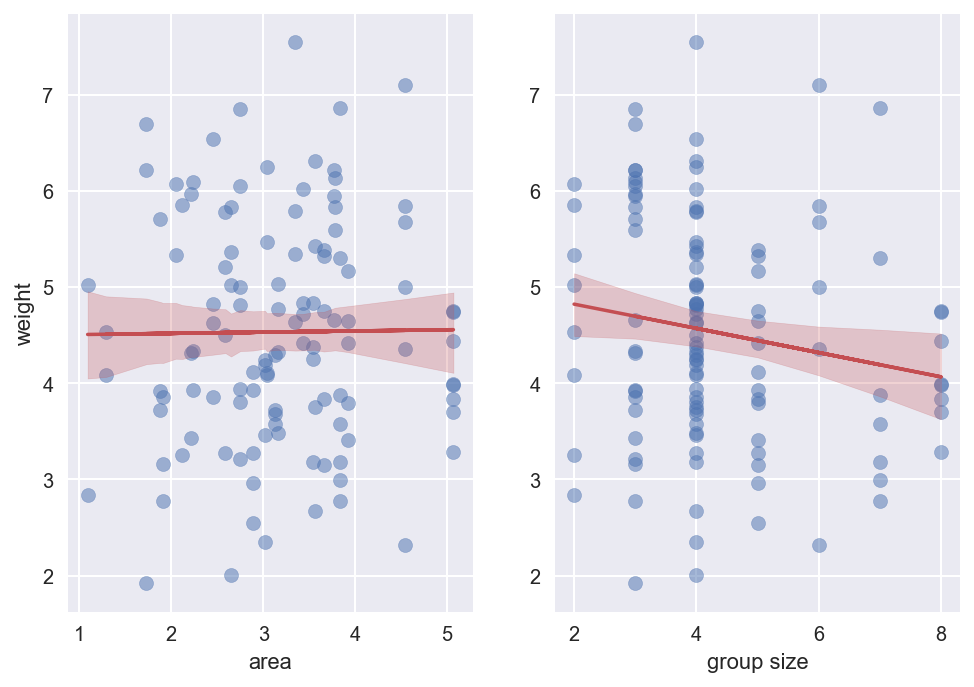

In [127]:
plt.subplot(121)
plot_regression_line(x=foxes['area'], y=foxes['weight'], mu=trace_m5h1a['mu'],
                    xlab='area', ylab='weight')

plt.subplot(122)
plot_regression_line(x=foxes['groupsize'], y=foxes['weight'], mu=trace_m5h1b['mu'],
                    xlab='group size')

**Territory area**: No strong indication of a relationship. The mean is close to 0 and the HPDI covers large amounts of both positive and negative values.

**Group size**: Decent indication of a negative association. The 89% HPDI is completely in the negative region.

***

**5H2.** Now ft a multiple linear regression with weight as the outcome and both area and groupsize as predictor variables. Plot the predictions of the model for each predictor, holding the other predictor constant at its mean. What does this model say about the importance of each variable? Why do you get different results than you got in the exercise just above?

In [128]:
with pm.Model() as m5h1c:
    a = pm.Normal('a', 5, 3)
    b_g = pm.Normal('b_g', 0, 3)
    b_a = pm.Normal('b_a', 0, 3)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', a + b_g * foxes['groupsize'] + b_a * foxes['area'])
    weight = pm.Normal('weight', mu, sigma, observed=foxes['weight'])
    
    trace_m5h1c = pm.sample(800, tune=400)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_a, b_g, a]
Sampling 3 chains: 100%|█████████| 3600/3600 [00:05<00:00, 670.12draws/s]
The acceptance probability does not match the target. It is 0.9014582246380638, but should be close to 0.8. Try to increase the number of tuning steps.


In [143]:
# pm.traceplot(trace_m5h1c);

print(pm.summary(trace_m5h1c, ['a', 'b_g', 'b_a', 'sigma'], alpha=0.11))

           mean        sd  mc_error   hpd_5.5  hpd_94.5        n_eff      Rhat
a      4.466439  0.373653  0.008242  3.868895  5.056385  1588.644430  0.999667
b_g   -0.426955  0.122763  0.002819 -0.620163 -0.235602  1454.250869  0.999455
b_a    0.604927  0.205534  0.005154  0.260901  0.906179  1285.814555  0.999444
sigma  1.144813  0.076540  0.001945  1.022927  1.260521  1606.430831  1.000520


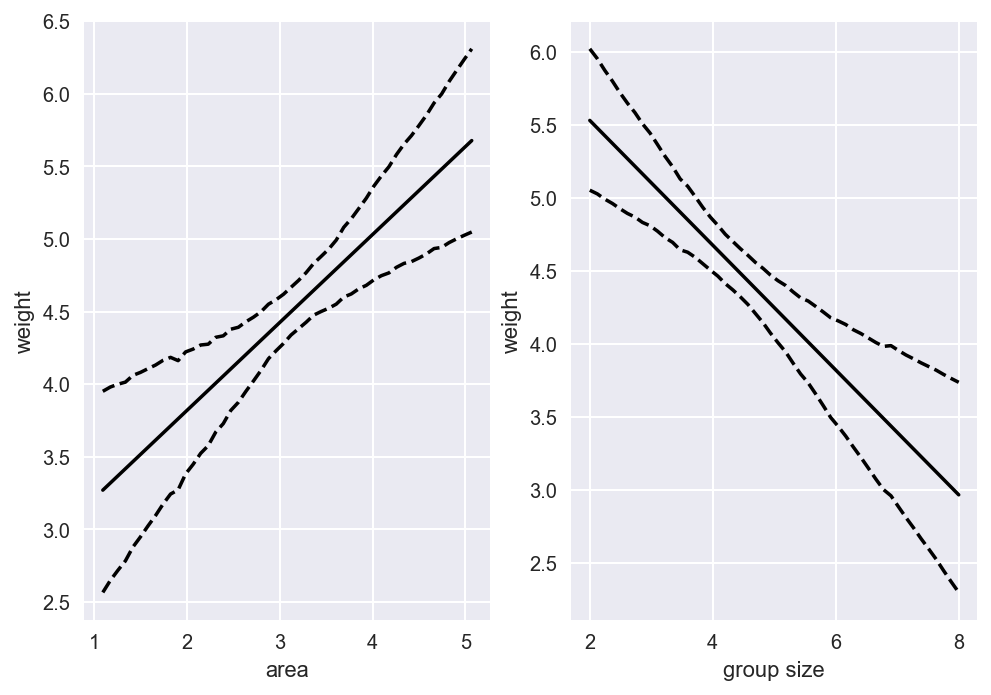

In [137]:
plt.subplot(121)
plot_counterfactual(data=foxes, trace=trace_m5h1c, variables=['area', 'groupsize'],
                   parameters=['b_a', 'b_g'], hpdi=0.11,
                   xlab='area', ylab='weight')

plt.subplot(122)
plot_counterfactual(data=foxes, trace=trace_m5h1c, variables=['groupsize', 'area'],
                   parameters=['b_g', 'b_a'], hpdi=0.11,
                   xlab='group size', ylab='weight')

Now both of the variables appear to have a pretty apparent effect (i.e., very low probability of being 0).

The masking effect was probably due to correlation:

[[1.         0.82759448]
 [0.82759448 1.        ]]


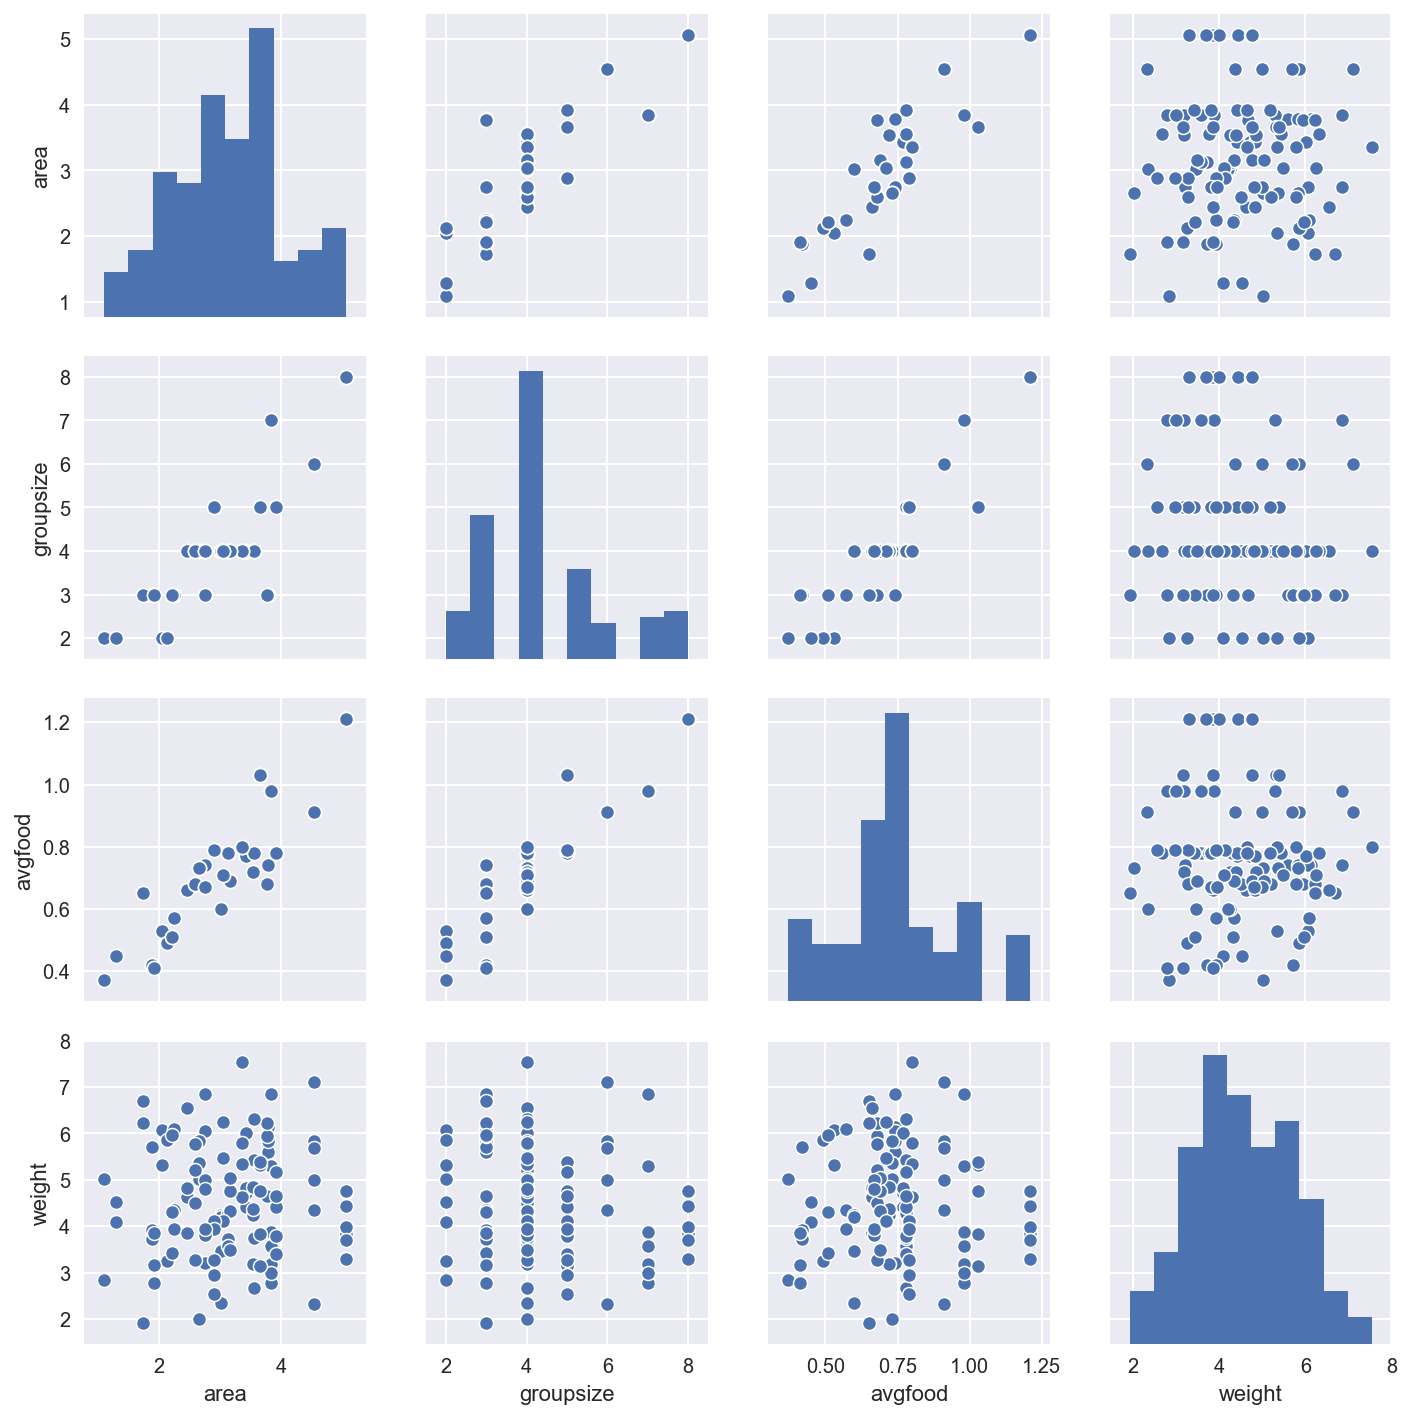

In [134]:
print(np.corrcoef(foxes['area'], foxes['groupsize']))

sns.pairplot(foxes, vars=['area', 'groupsize', 'avgfood', 'weight']);

***

**5H3.** Finally, consider the avgfood variable. Fit two more multiple regressions: (1) body weight as an additive function of avgfood and groupsize, and (2) body weight as an additive function of all three variables, avgfood and groupsize and area. Compare the results of these models to the previous models you’ve ft, in the frst two exercises. (a) Is avgfood or area a better predictor of body weight? If you had to choose one or the other to include in a model, which would it be? Support your assessment with any tables or plots you choose. (b) When both avgfood or area are in the same model, their eﬀects are reduced (closer to zero) and their standard errors are larger than when they are included in separate models. Can you explain this result?

In [138]:
# 2 parameter model
with pm.Model() as m5h3a:
    a = pm.Normal('a', 5, 3)
    b_g = pm.Normal('b_g', 0, 3)
    b_af = pm.Normal('b_af', 0, 3)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', a + b_g * foxes['groupsize'] + b_af * foxes['avgfood'])
    weight = pm.Normal('weight', mu, sigma, observed=foxes['weight'])
    
    trace_m5h3a = pm.sample(800, tune=400)
    
# 3 parameter model
with pm.Model() as m5h3b:
    a = pm.Normal('a', 5, 3)
    b_g = pm.Normal('b_g', 0, 3)
    b_af = pm.Normal('b_af', 0, 3)
    b_a = pm.Normal('b_a', 0, 3)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', a + b_g * foxes['groupsize'] + b_af * foxes['avgfood']
                         + b_a * foxes['area'])
    weight = pm.Normal('weight', mu, sigma, observed=foxes['weight'])
    
    trace_m5h3b = pm.sample(800, tune=400)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_af, b_g, a]
Sampling 3 chains: 100%|█████████| 3600/3600 [00:06<00:00, 599.01draws/s]
The acceptance probability does not match the target. It is 0.8922865697767273, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8972098770766692, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_a, b_af, b_g, a]
Sampling 3 chains: 100%|█████████| 3600/3600 [00:07<00:00, 451.27draws/s]
The acceptance probability does not match the target. It is 0.8842465237152819, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796843264316176, but should be clo

In [142]:
# pm.traceplot(trace_m5h3a);
# pm.traceplot(trace_m5h3b);

print(pm.summary(trace_m5h3a, ['a', 'b_g', 'b_af', 'sigma'], alpha=0.11))

print(pm.summary(trace_m5h3b, ['a', 'b_g', 'b_af', 'b_a', 'sigma'], alpha=0.11))



           mean        sd  mc_error   hpd_5.5  hpd_94.5        n_eff      Rhat
a      4.262452  0.423355  0.011885  3.626122  4.941766  1245.058160  0.999923
b_g   -0.507524  0.146509  0.004264 -0.746743 -0.292674  1029.567869  1.001196
b_af   3.285701  1.112242  0.036297  1.444596  4.912295   865.608951  0.999916
sigma  1.146341  0.081826  0.002340  1.007630  1.266939  1259.129521  0.999618
           mean        sd  mc_error   hpd_5.5  hpd_94.5        n_eff      Rhat
a      4.153118  0.428689  0.012451  3.496160  4.841383  1079.676385  1.000603
b_g   -0.570408  0.155118  0.005091 -0.796197 -0.307112   956.574100  1.002547
b_af   1.998838  1.351421  0.047539 -0.227026  4.076552   780.802776  1.000423
b_a    0.427549  0.239006  0.006753  0.041520  0.792808  1335.679382  1.001597
sigma  1.136485  0.075048  0.002189  1.024057  1.260105  1453.713414  0.999867


In the model with 2 predictors, `avgfood` is positively associated with weight. However, in the model with 3 predictors this effect appears to be dampened.

`area` appears to be a "better" predictor, though it is hard to conclude. The HPDI for `b_a` still remains almost entirely positive whereas `b_af` goes from strongly positive to having some probability in the negative space.

This is probably because `area` and `avgfood` contain similar information (i.e., correlation leading to multicollinearity). The sd for both `b_a` and `b_af` increased by ~20% compared to the 2-predictor models.